### Importing Packages, Dataset, Basic Data Wrangling

In [1]:
# Importing pacakges and loading dataset
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('COE.xls', sheet_name='COE', header=0)

df = df.iloc[:,:-2]
df['Date'] = pd.to_datetime(df['Date'])

df.set_index(df['Date'],inplace=True)
df.drop(columns=['SAS Date','Wednesday?','Date'], inplace=True)

df = pd.concat([df.pop('CatECOE'),df],axis=1)

df

CatECOE  CatACOE  CatAQuota  CatABids  CatBCOE  CatBQuota  \
Date                                                                    
2002-03-15    34501    33201       1468      2800    34200        651   
2002-04-01    41001    37201       1110      2484    39509        558   
2002-04-15    42043    36000       1149      1890    42101        553   
2002-05-01    40001    35000       1128      1705    40001        560   
2002-05-15    38399    33401       1111      1320    38001        552   
...             ...      ...        ...       ...      ...        ...   
2020-01-15    37500    35010       1034      1390    37705       1012   
2020-02-01    34900    30010        982      1204    30890        984   
2020-02-15    33301    32999        982      1564    32889        987   
2020-03-01    32500    32699        978      1436    32801        987   
2020-03-15    32500    31210        982      1421    30012        992   

            CatBBids  CatEQuota  CatEBids  
Date                                       
2002-03-15      1052        817      1594  
2002-04-01      1119        682      1797  
2002-04-15      1104        754      1407  
2002-05-01      1043        960      1880  
2002-05-15       894        910      1835  
...              ...        ...       ...  
2020-01-15      1157        388       528  
2020-02-01      1173        335       525  
2020-02-15      1459        328       550  
2020-03-01      1347        333       512  
2020-03-15      1366        331       503  

[433 rows x 9 columns]

### Determining Stationarity

In [2]:
# Check stationary / non-stationary of exogenous variables
from statsmodels.tsa.stattools import adfuller

for item in list(df.columns):
    result = adfuller(df[item].dropna(inplace=False))
    
    print('\n###',item,'###\n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print('\nTime Series for',item,'is stationary. (d=0)')
    else:
        print('\nTime Series for',item,'is not stationary. (d>0)')


### CatECOE ###

ADF Statistic: -1.388494
p-value: 0.587780
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570

Time Series for CatECOE is not stationary. (d>0)

### CatACOE ###

ADF Statistic: -1.069320
p-value: 0.727150
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570

Time Series for CatACOE is not stationary. (d>0)

### CatAQuota ###

ADF Statistic: -1.387169
p-value: 0.588412
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570

Time Series for CatAQuota is not stationary. (d>0)

### CatABids ###

ADF Statistic: -1.998998
p-value: 0.287013
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570

Time Series for CatABids is not stationary. (d>0)

### CatBCOE ###

ADF Statistic: -1.390409
p-value: 0.586865
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571

Time Series for CatBCOE is not stationary. (d>0)

### CatBQuota ###

ADF Statistic: -1.426784
p-value: 0.569370
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570

Time Series for CatBQuota is not stationary. (d>0)


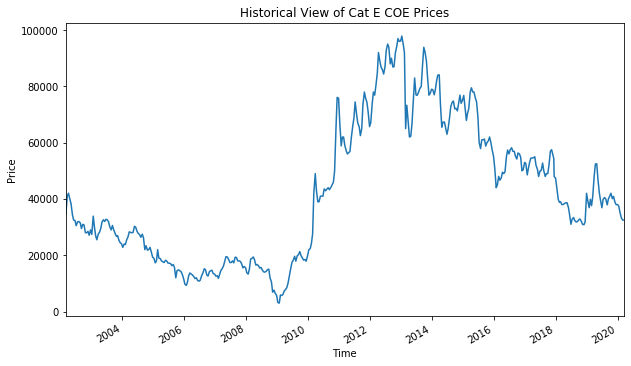

In [3]:
# Initial Visualization of CatECOE Time Series
plt.figure(figsize=(10,6))
df.CatECOE.plot()
plt.title('Historical View of Cat E COE Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

### Time Series Decomposition

In [4]:
import re, os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import warnings
%matplotlib inline

from math import sqrt
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error

ts = df.CatECOE.copy()
ts

Date
2002-03-15    34501
2002-04-01    41001
2002-04-15    42043
2002-05-01    40001
2002-05-15    38399
              ...  
2020-01-15    37500
2020-02-01    34900
2020-02-15    33301
2020-03-01    32500
2020-03-15    32500
Name: CatECOE, Length: 433, dtype: int64

In [5]:
### Time Series Decomposition Function
# data:                 [Series, DataFrame] time series data
# model_type:           ['add', 'mul'] Additive or Multiplicative Models to use for time series decomposition
# freq:                 [<int>] number of periods in a season
# n_obs:                [<int>] last n number of data point to view in decomposition plot

def ts_visualize(decomposition, n_obs=365):
    if len(decomposition.observed) > n_obs:
        
        try:
            decomposition.observed = decomposition.observed[-n_obs:]
            decomposition.trend = decomposition.trend[-n_obs:]
            decomposition.seasonal = decomposition.seasonal[-n_obs:]
            decomposition.resid = decomposition.resid[-n_obs:]
        except:
            decomposition._observed = decomposition._observed[-n_obs:]
            decomposition._trend = decomposition._trend[-n_obs:]
            decomposition._seasonal = decomposition._seasonal[-n_obs:]
            decomposition._resid = decomposition._resid[-n_obs:]
        
        #plt.xticks(rotation=90)
        print('Last', n_obs, 'observations:')
        decomposition.plot()
        plt.show()


def ts_decomp(data, model_type='mul', freq=365):
    plt.rcParams['figure.figsize'] = 12, 15
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 1
    
    nr = data.shape[0]

    try:
        if 'mf4' in vars() or 'mf4' in globals() or 'mf4' in vars(__builtins__):
            del mf4 #delete d if defined during previous run
    except:
        pass
    
    mf4 = seasonal_decompose(data, model=model_type, freq=freq, extrapolate_trend='freq') #'extrapolate' removes NaN in 'trend'

    if model_type == 'mul':
        decomp_type = 'Multiplicative'
    elif model_type == 'add':
        decomp_type = 'Additive'
    
    print('\nTime Series Decomposition (' + decomp_type + ') for', nr, 'observations:')

    mf4.plot()
    plt.show()

    ts_visualize(mf4, n_obs=24) # latest year
    ts_visualize(mf4, n_obs=6) # latest quarter
    ts_visualize(mf4, n_obs=2) # latest month



##### Time Series Decomposition for CatECOE (freq=24) #####


Time Series Decomposition (Multiplicative) for 433 observations:


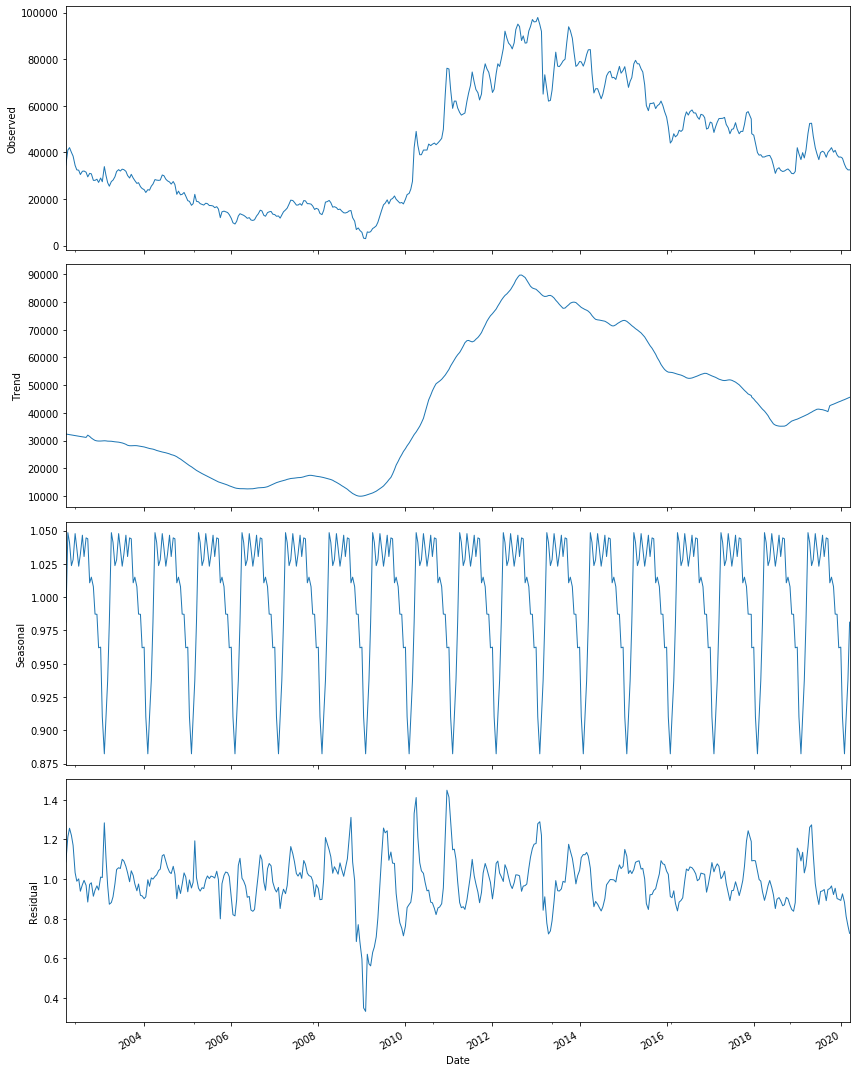

Last 24 observations:


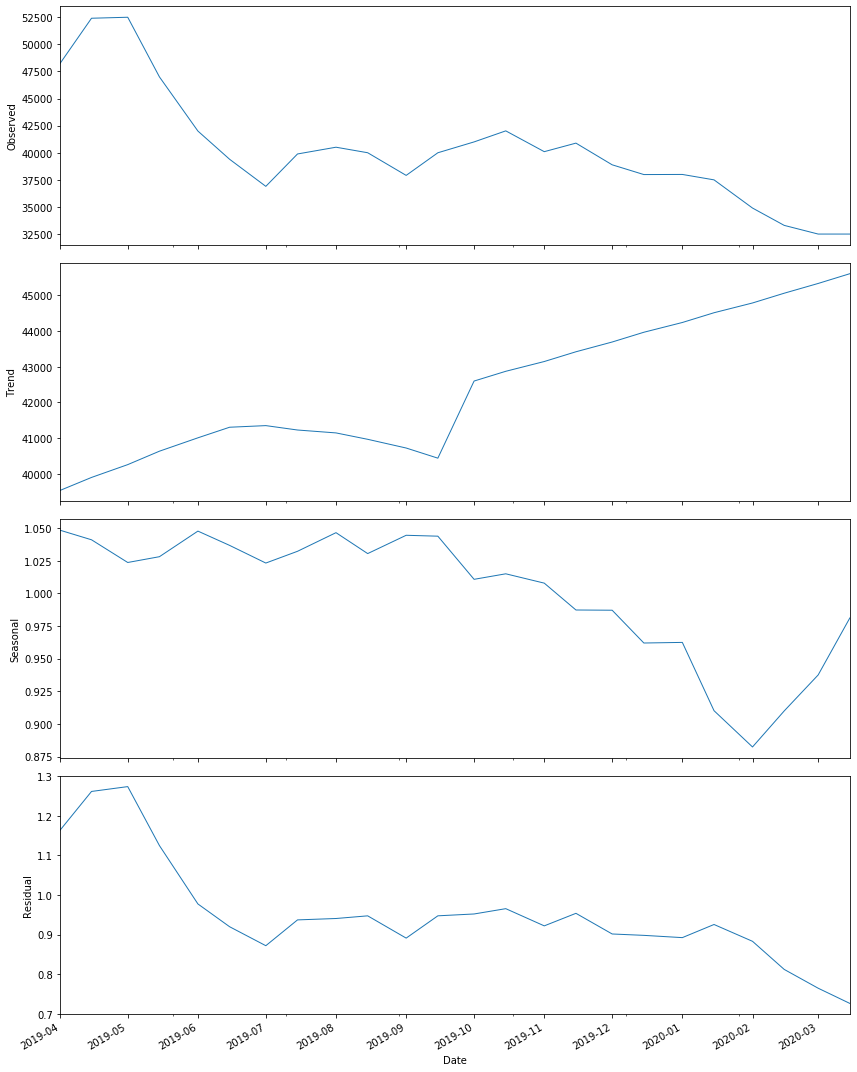

Last 6 observations:


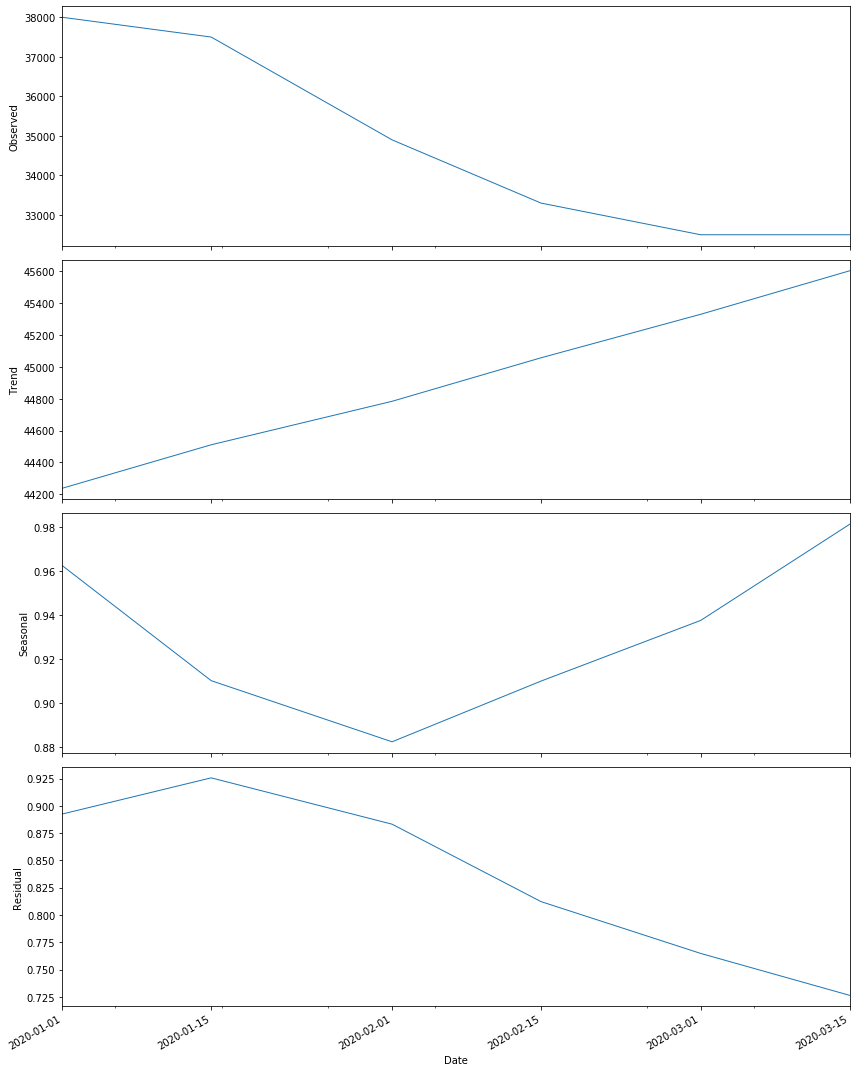

Last 2 observations:


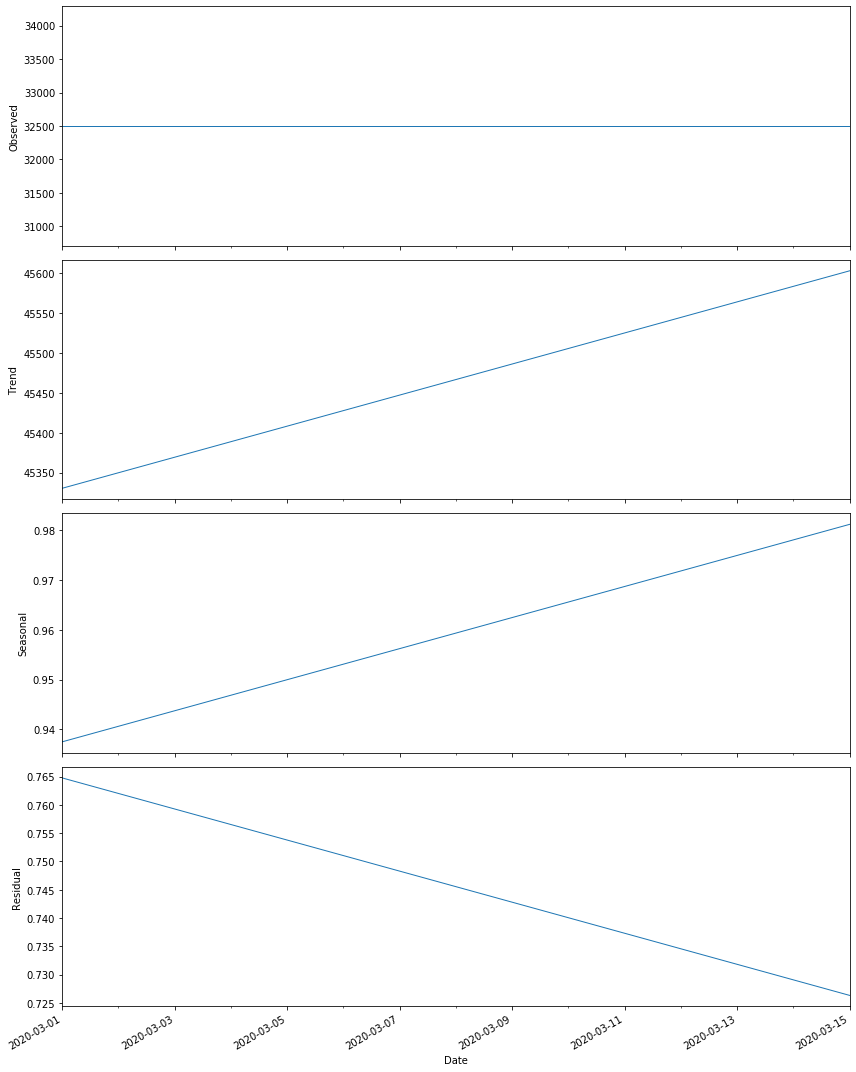


##### Time Series Decomposition for CatECOE (freq=12) #####


Time Series Decomposition (Multiplicative) for 433 observations:


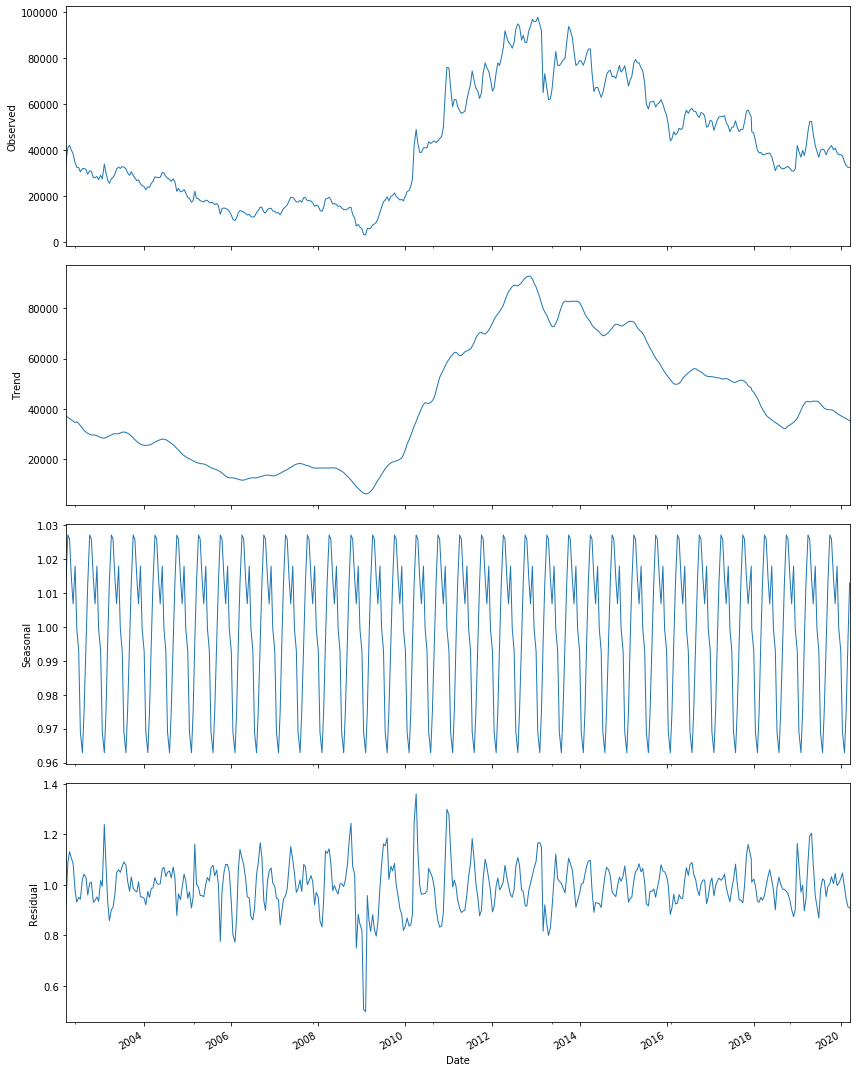

Last 24 observations:


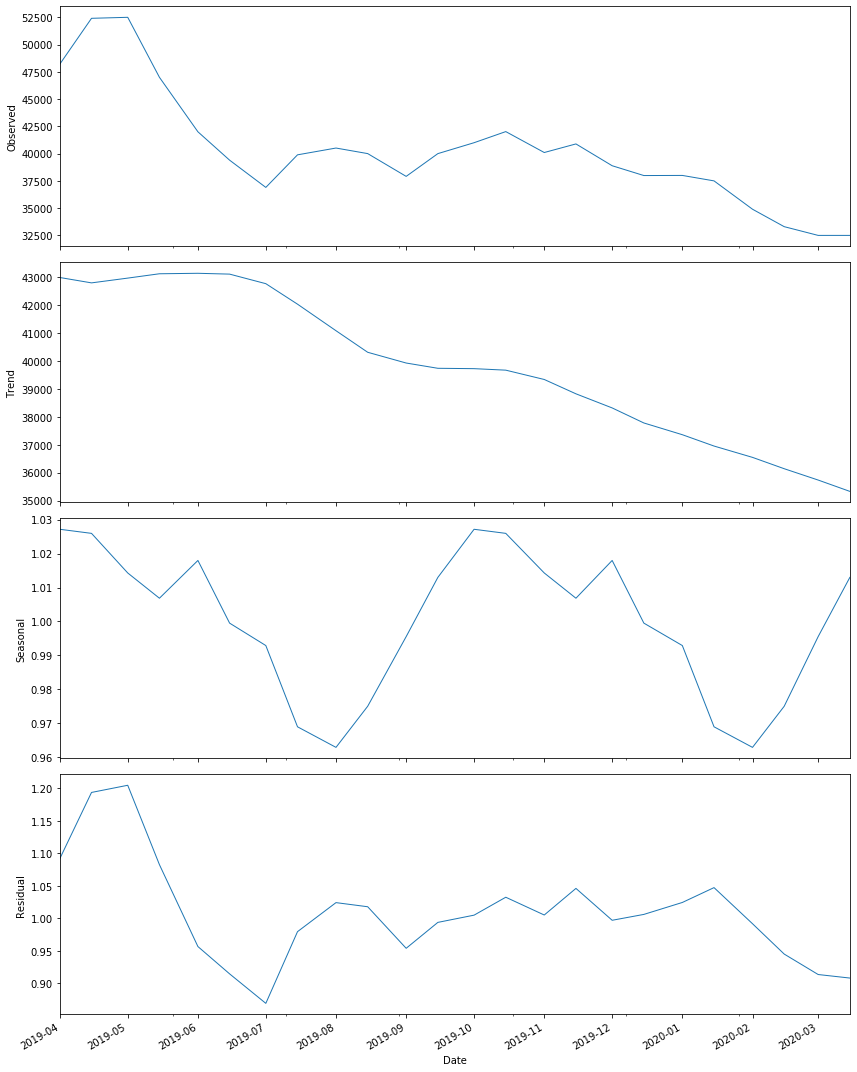

Last 6 observations:


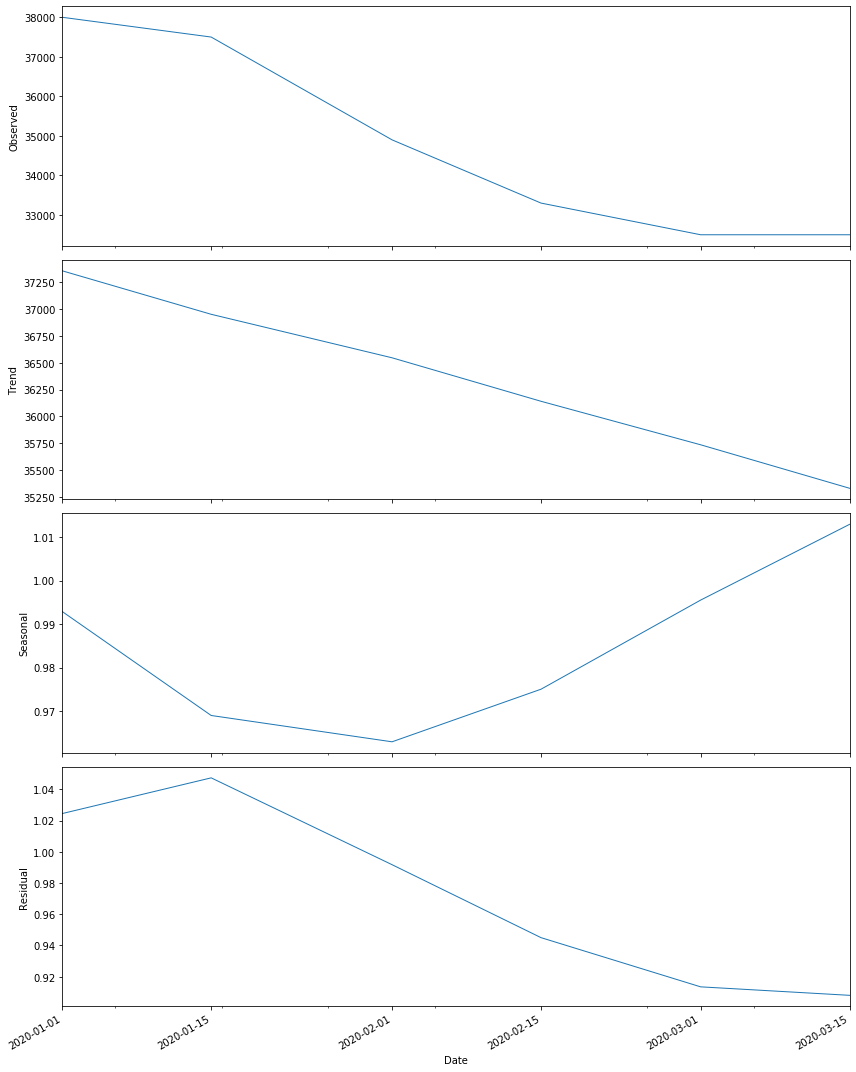

Last 2 observations:


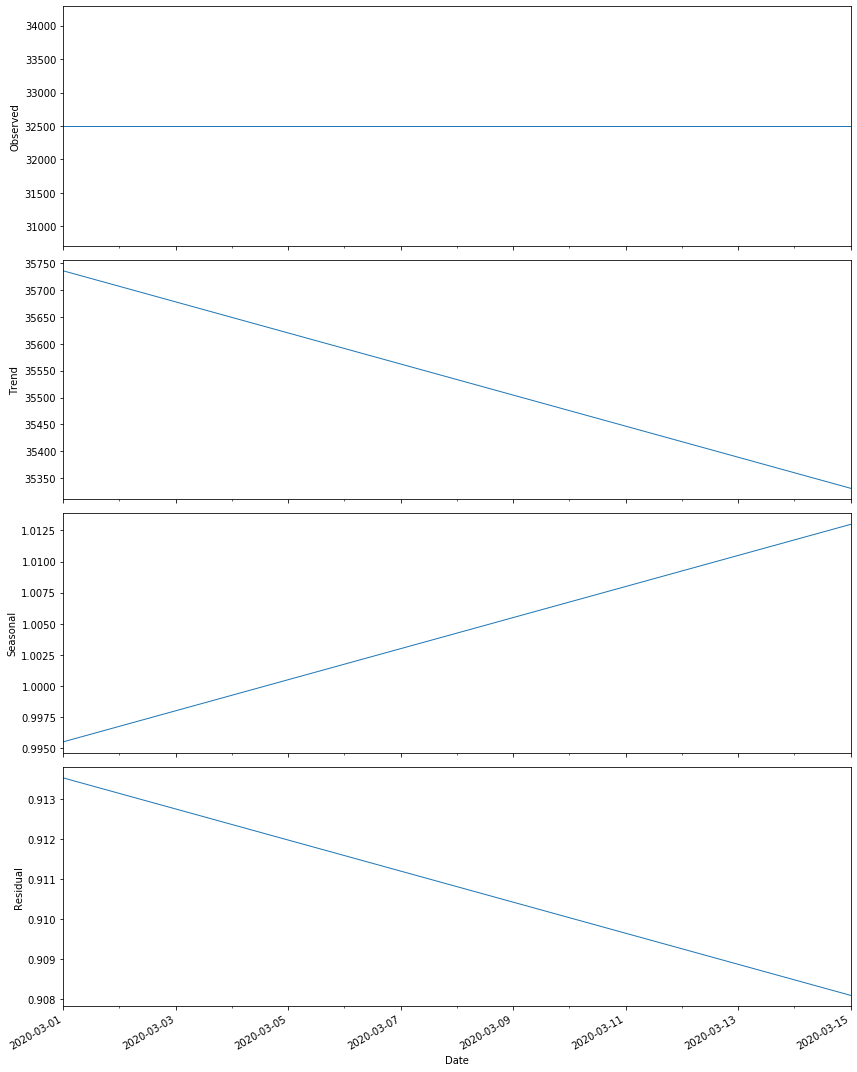


##### Time Series Decomposition for CatECOE (freq=6) #####


Time Series Decomposition (Multiplicative) for 433 observations:


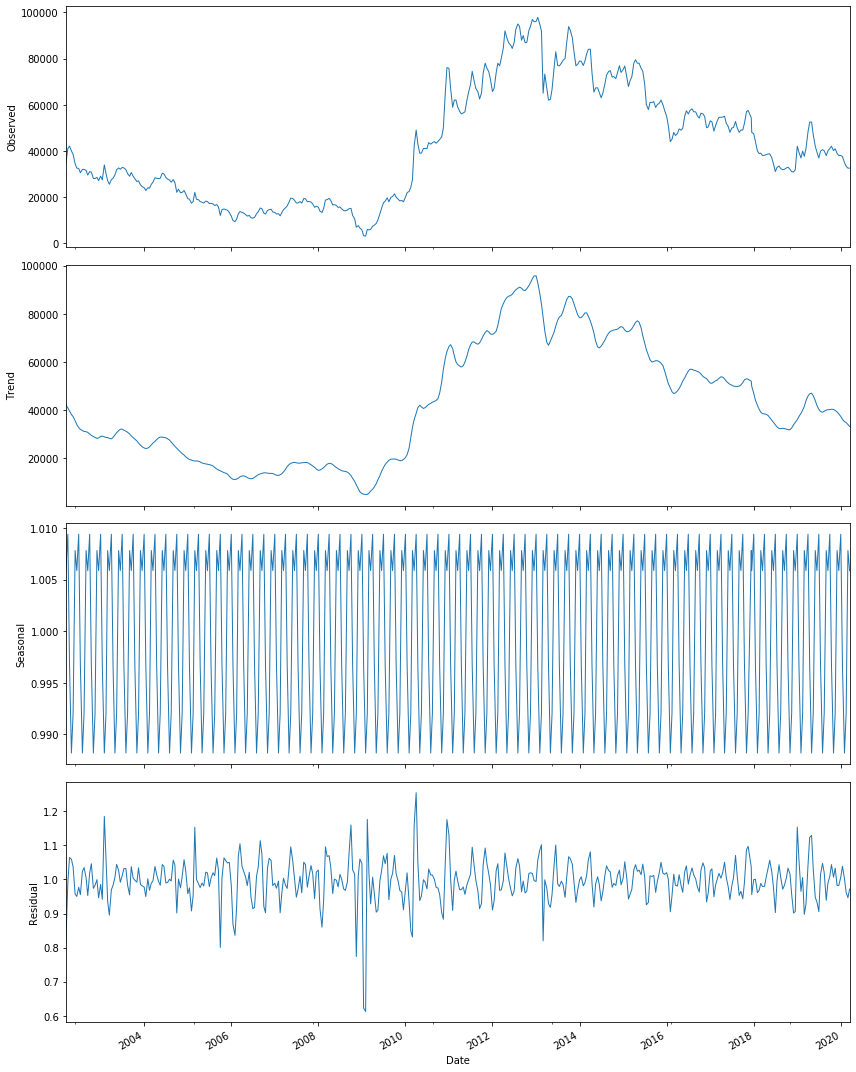

Last 24 observations:


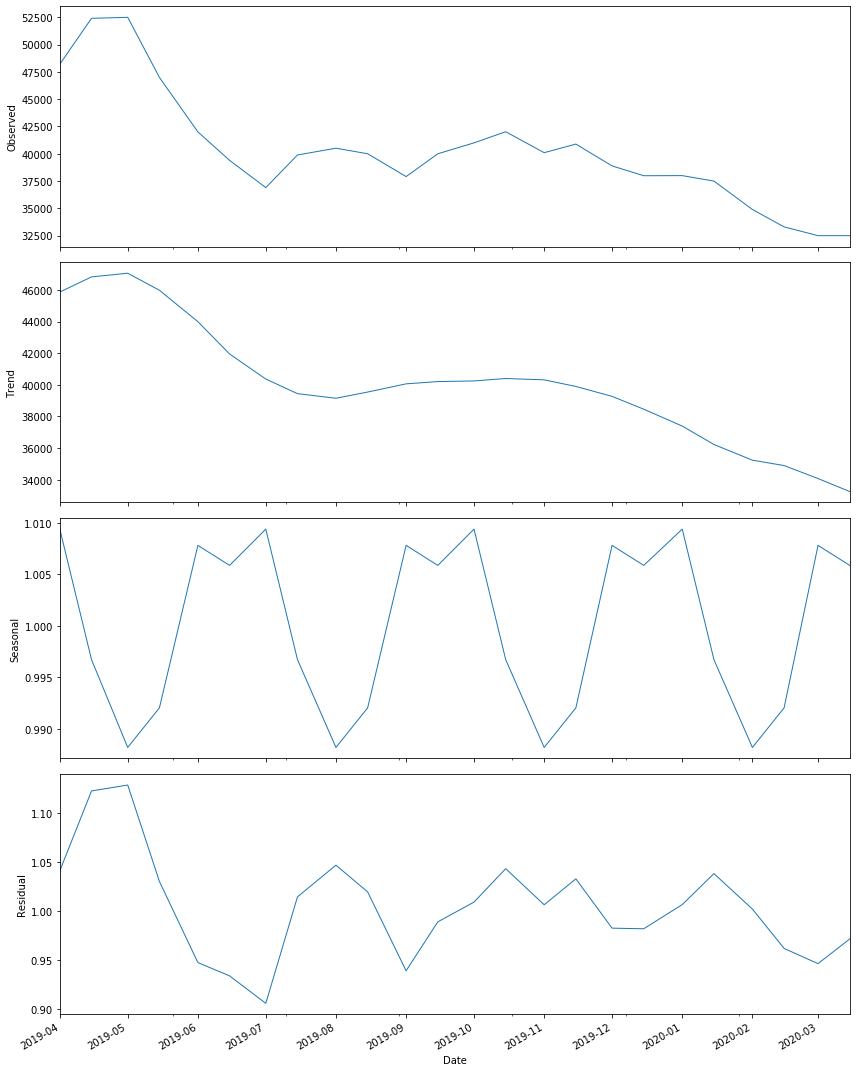

Last 6 observations:


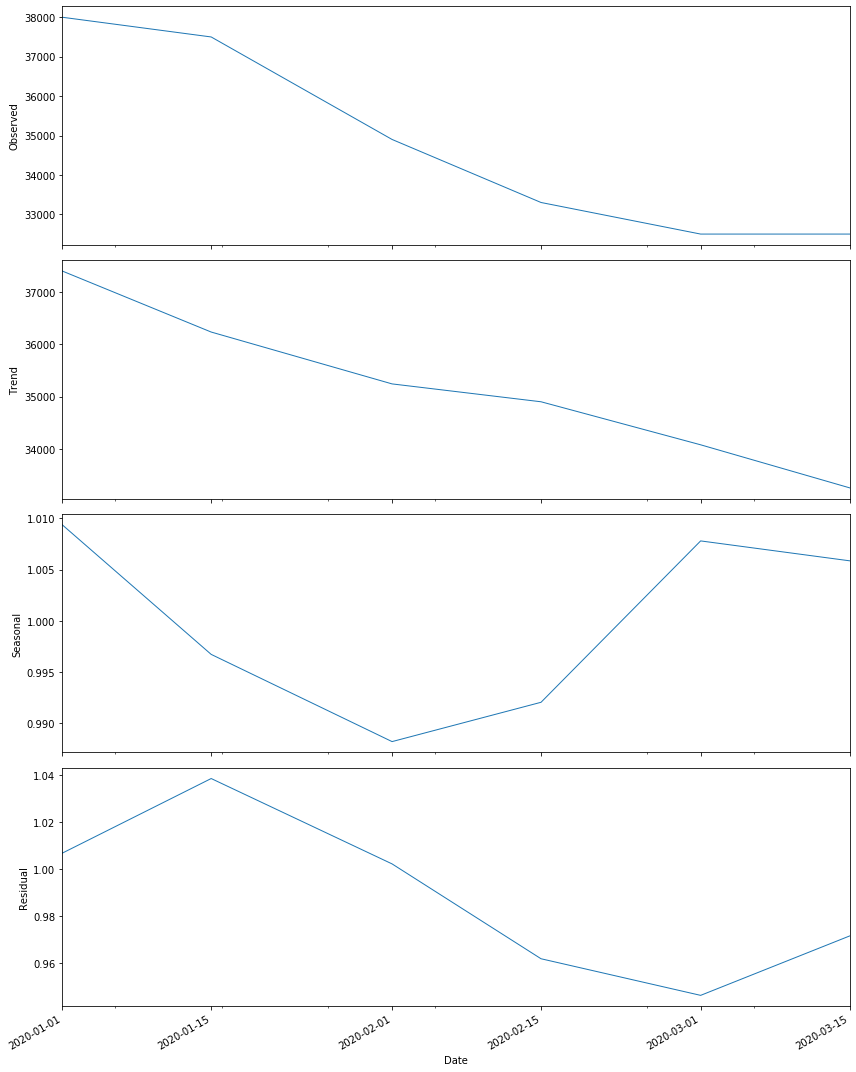

Last 2 observations:


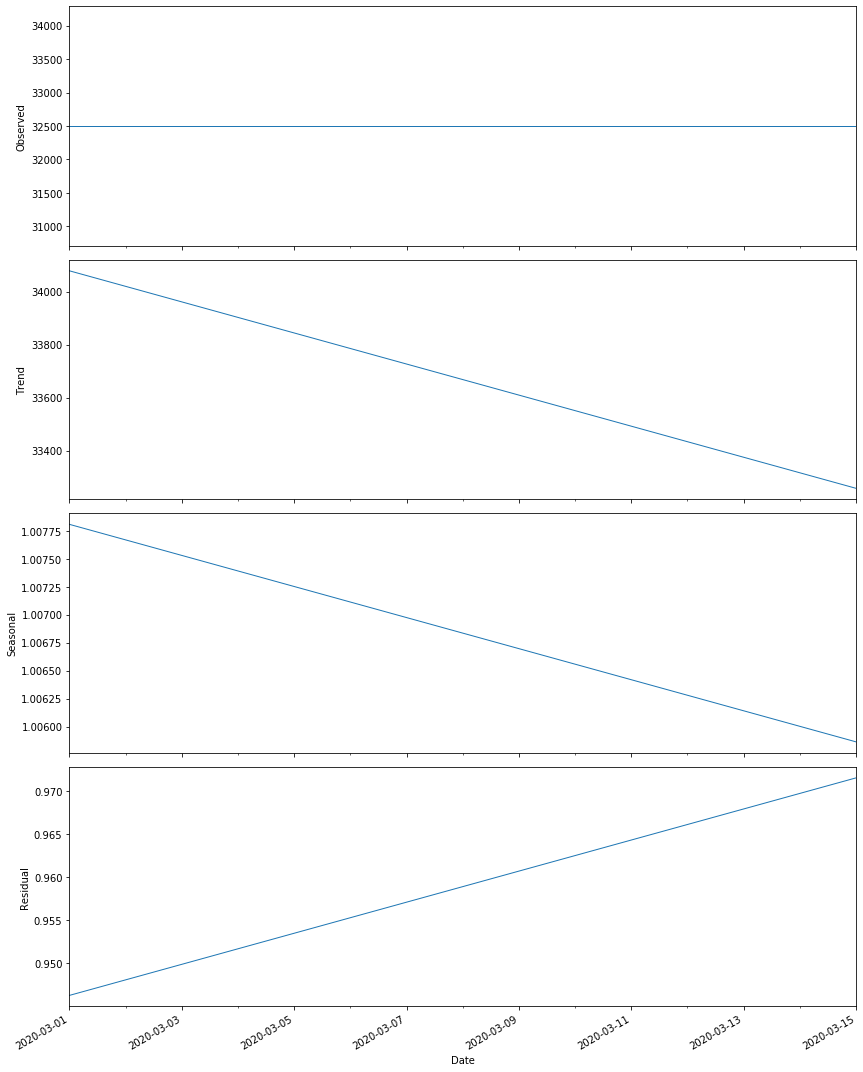


##### Time Series Decomposition for CatECOE (freq=2) #####


Time Series Decomposition (Multiplicative) for 433 observations:


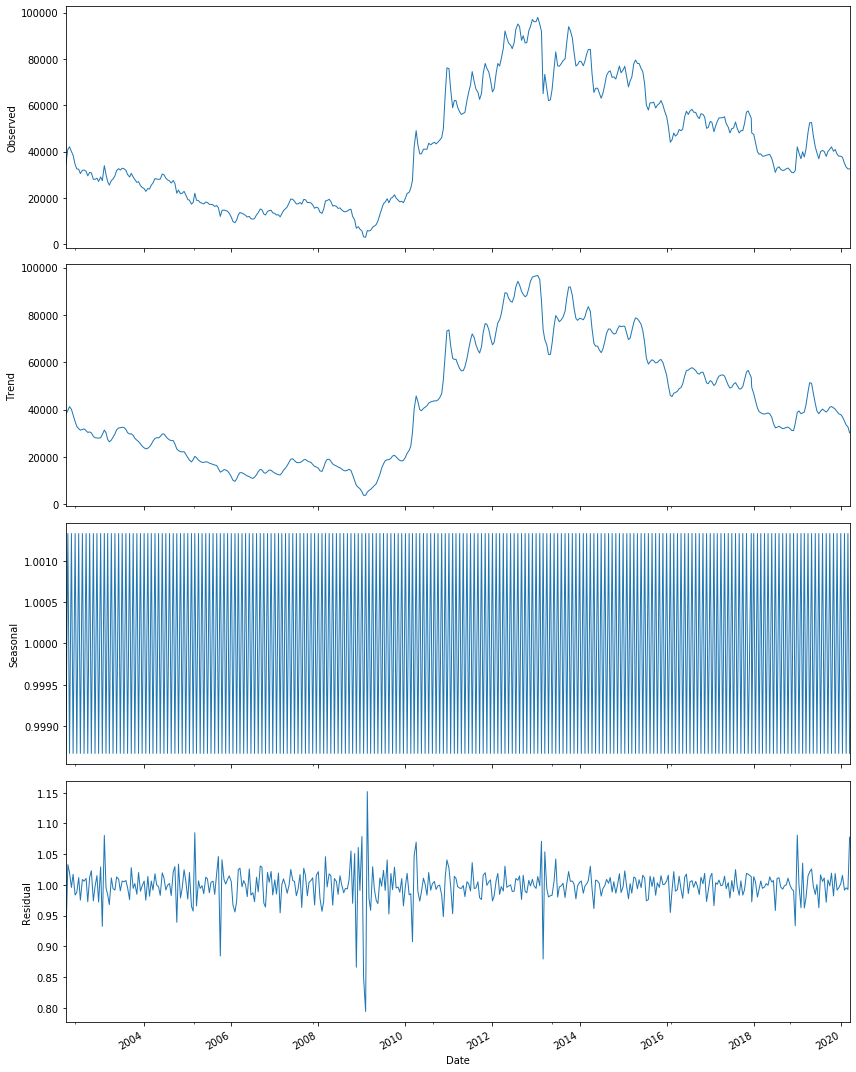

Last 24 observations:


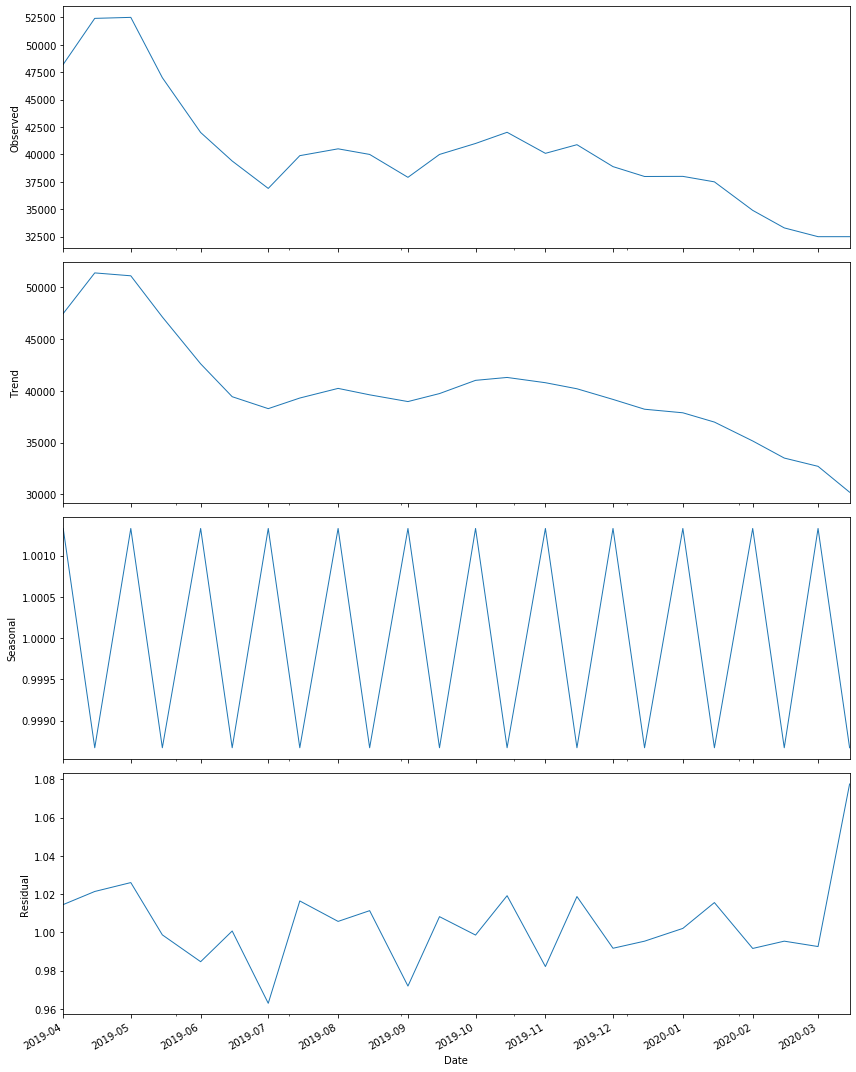

Last 6 observations:


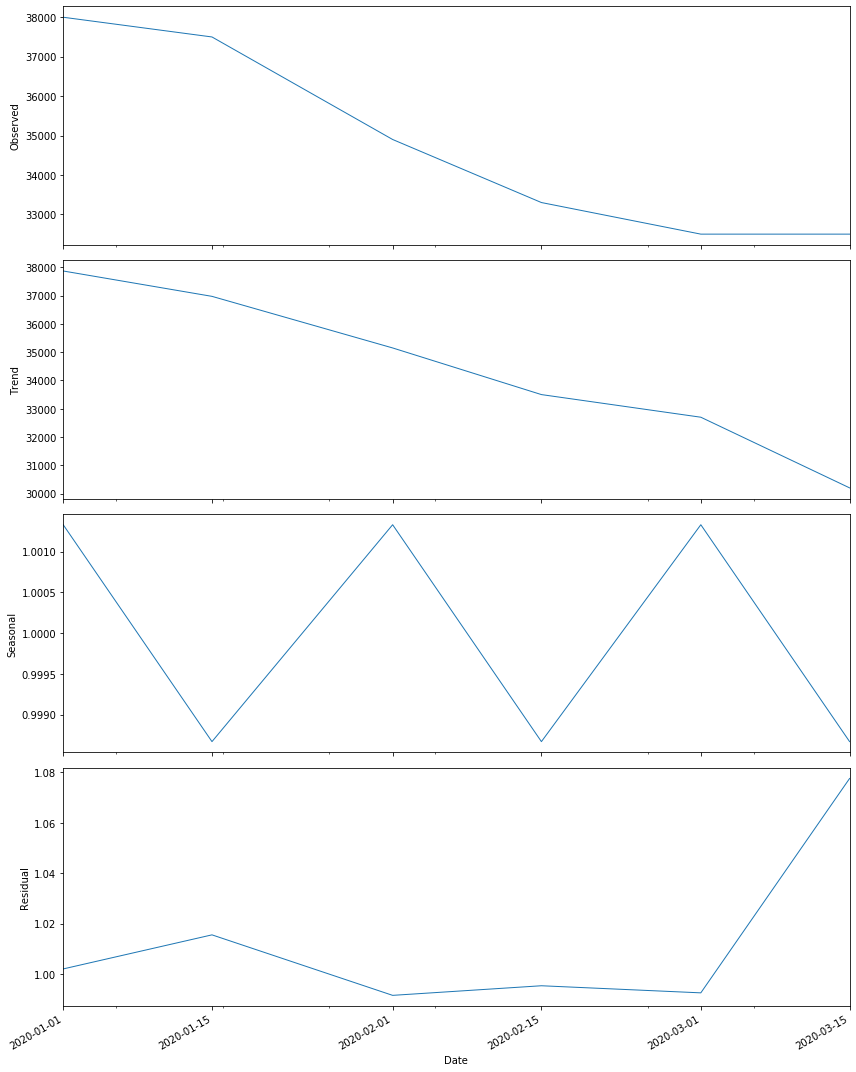

Last 2 observations:


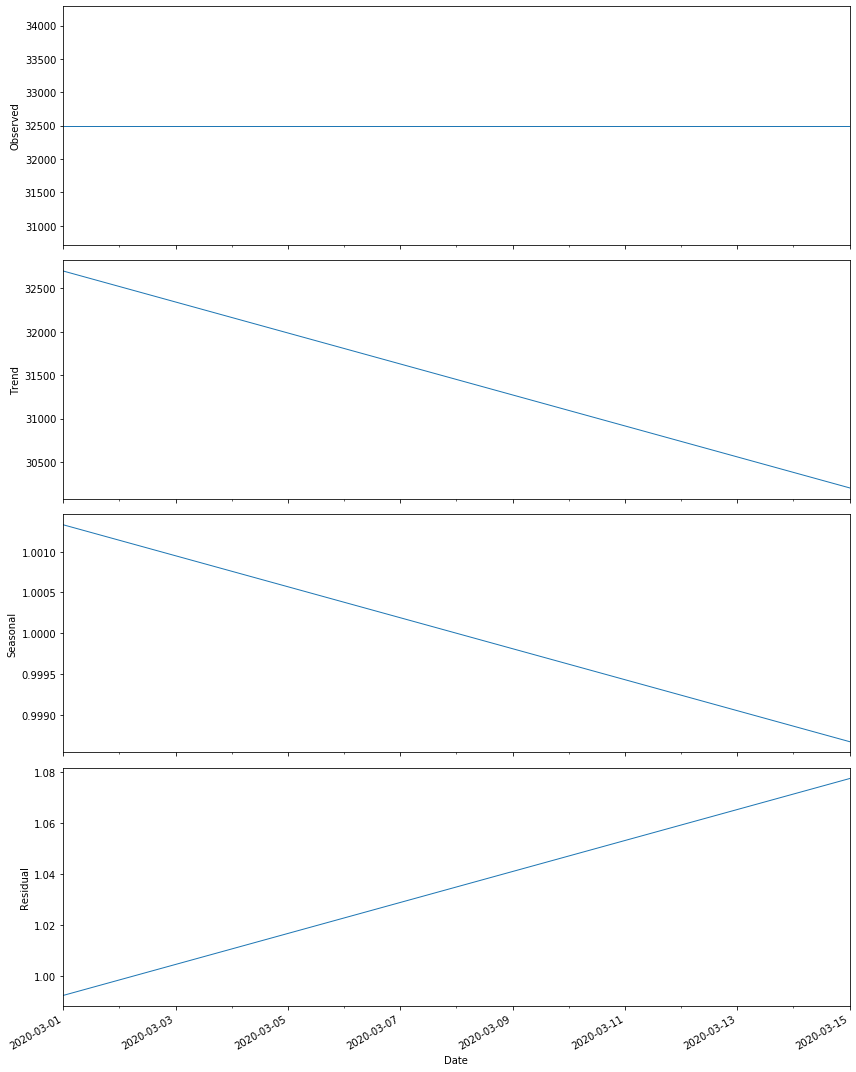


##### Time Series Decomposition for CatECOE (freq=1) #####


Time Series Decomposition (Multiplicative) for 433 observations:


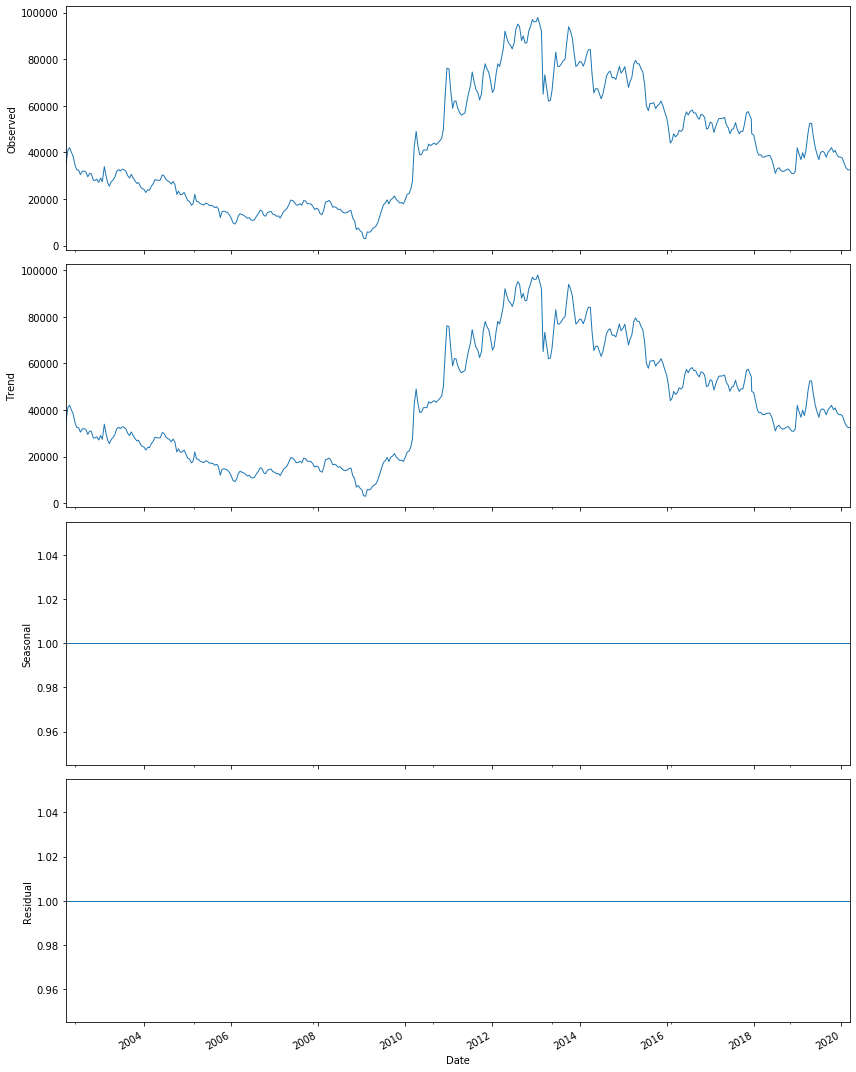

Last 24 observations:


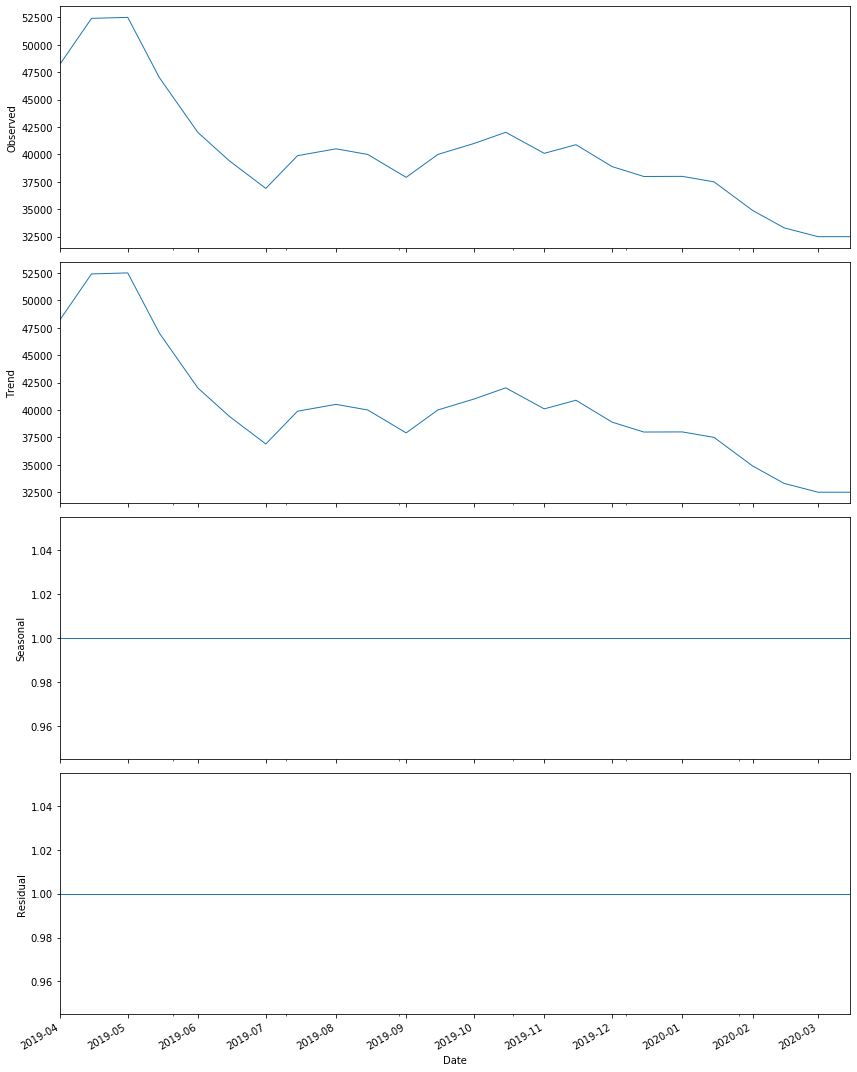

Last 6 observations:


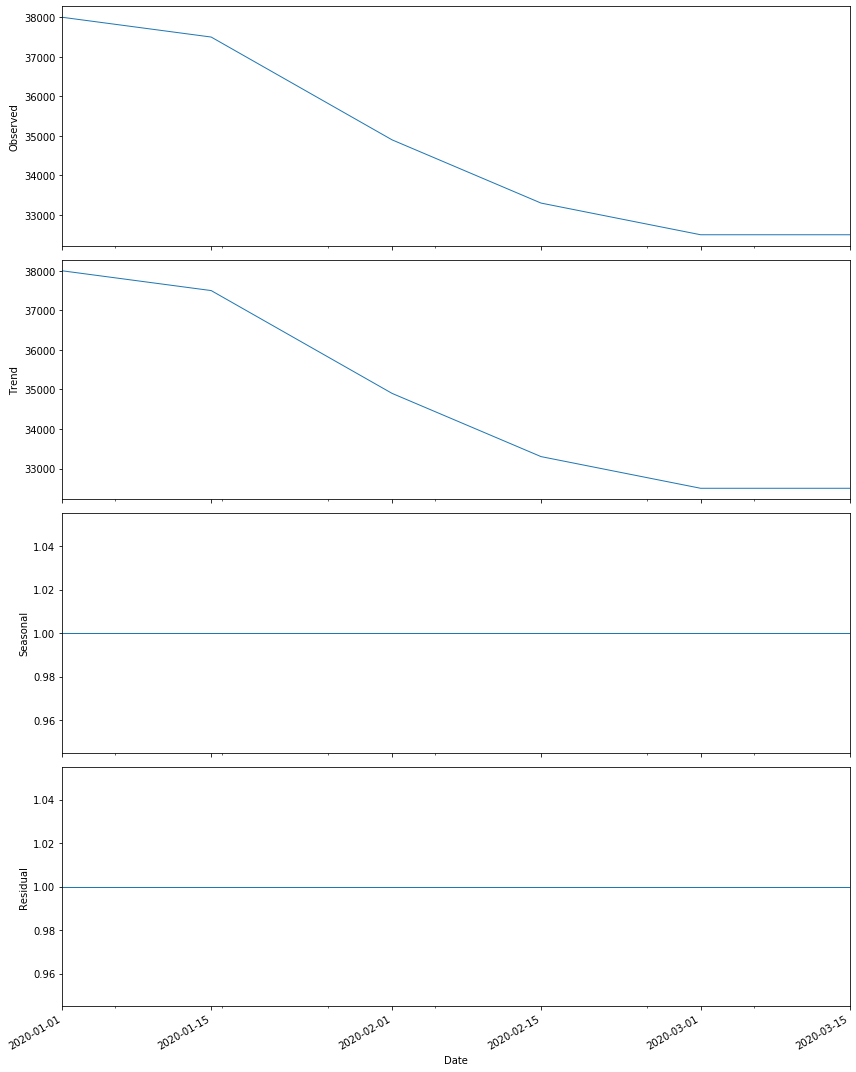

Last 2 observations:


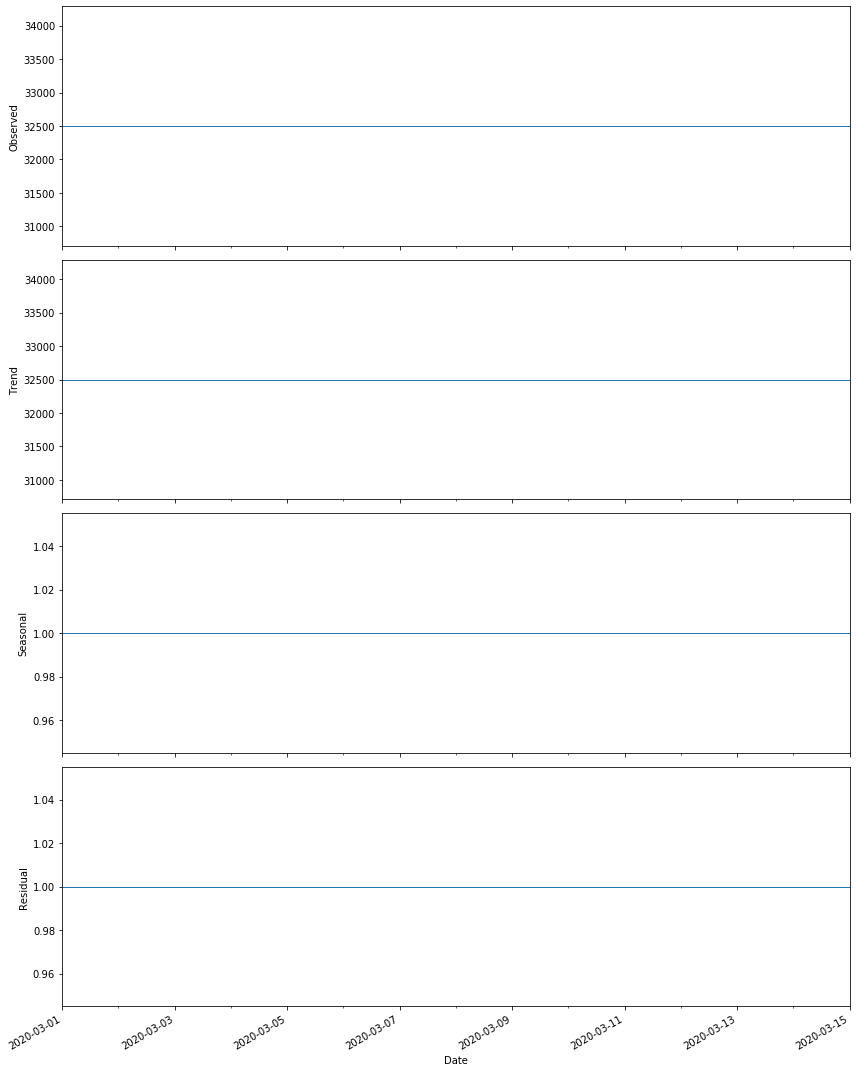

In [6]:
# TS Decomp (Yearly, Semiannually, Quarterly, Monthly, Periodically)
for i in [24, 12, 6, 2, 1]:
    print("\n##### Time Series Decomposition for CatECOE (freq="+str(i)+") #####\n")
    ts_decomp(ts, model_type='mul', freq=i)


##### Time Series Decomposition for CatACOE #####


Time Series Decomposition (Multiplicative) for 433 observations:


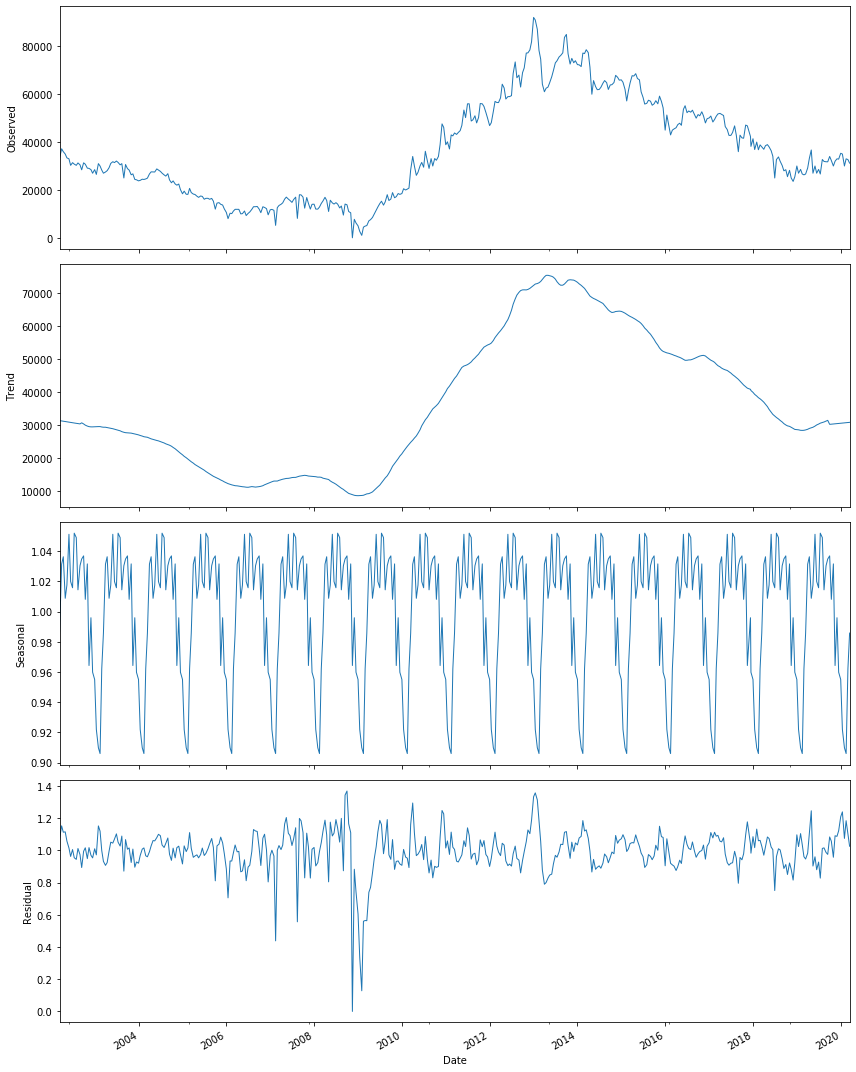

Last 24 observations:


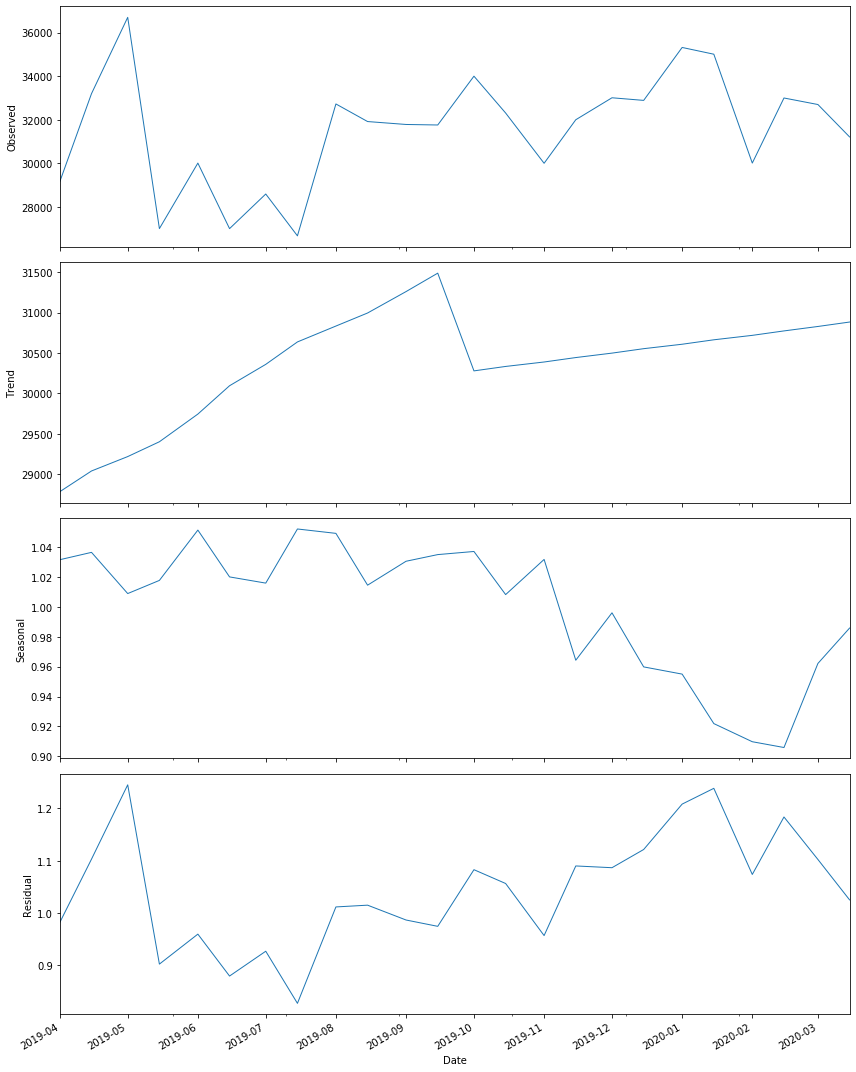

Last 6 observations:


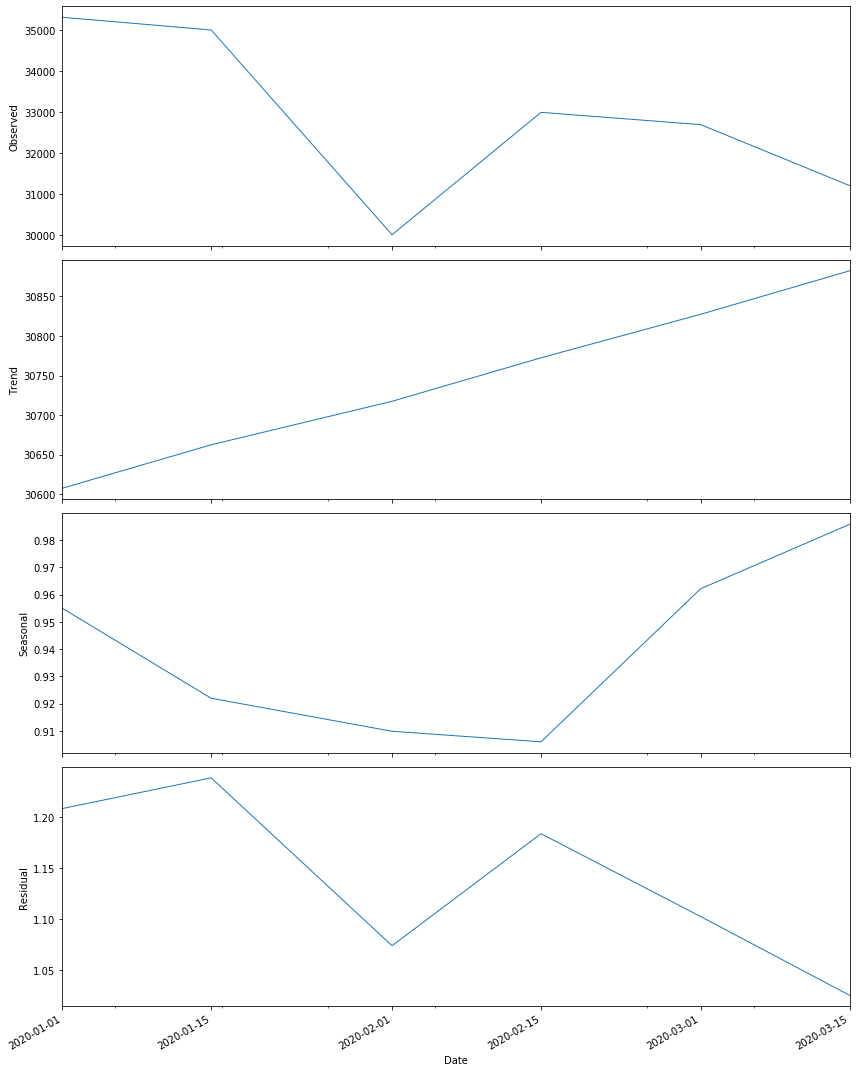

Last 2 observations:


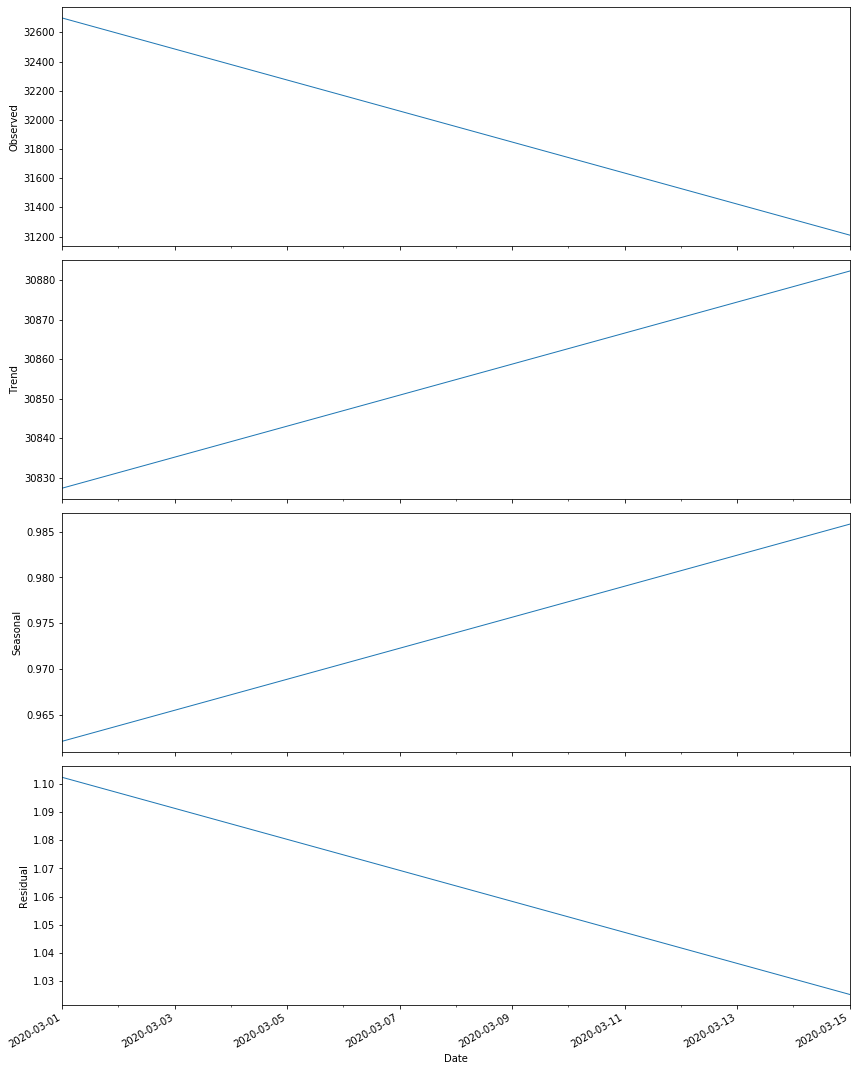


##### Time Series Decomposition for CatAQuota #####


Time Series Decomposition (Multiplicative) for 433 observations:


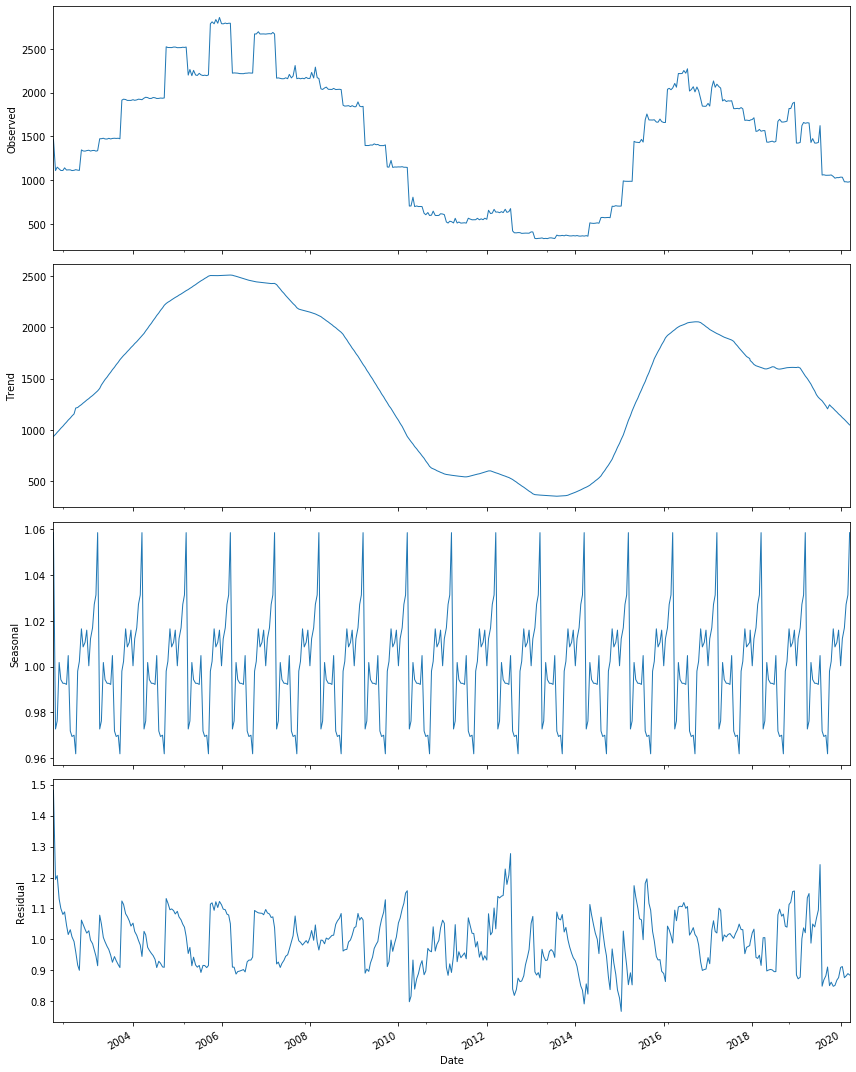

Last 24 observations:


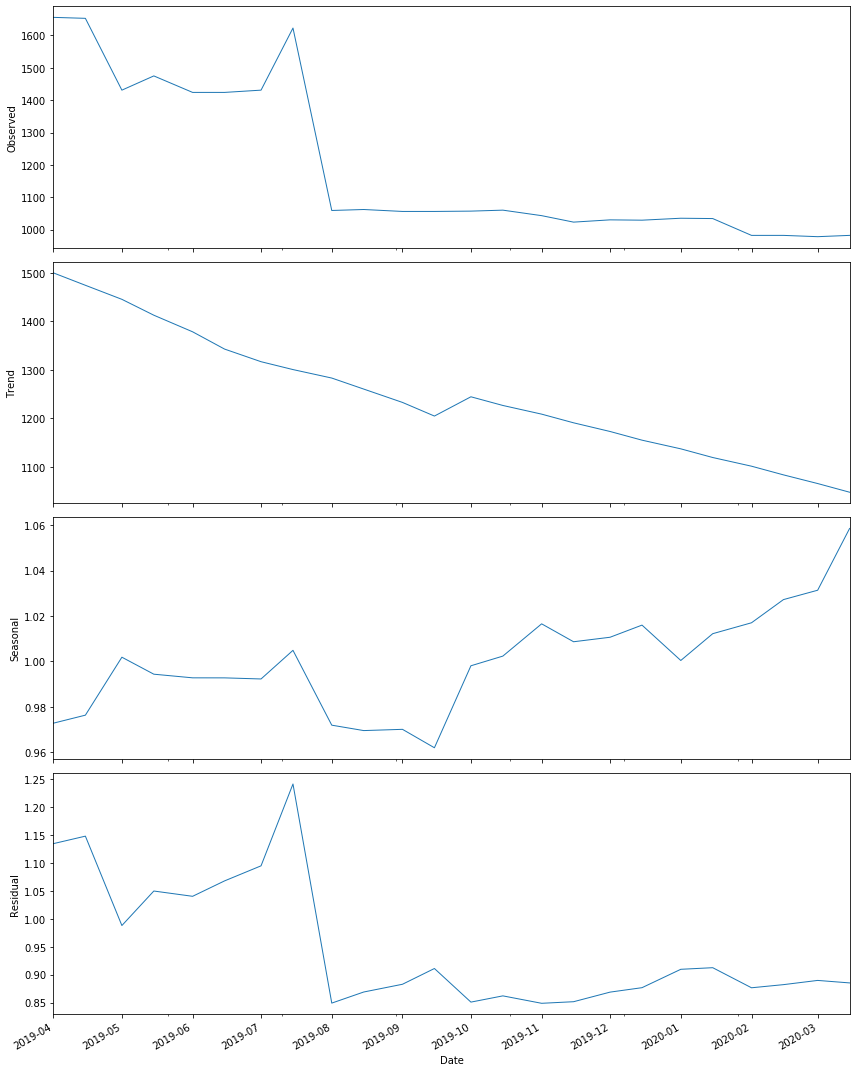

Last 6 observations:


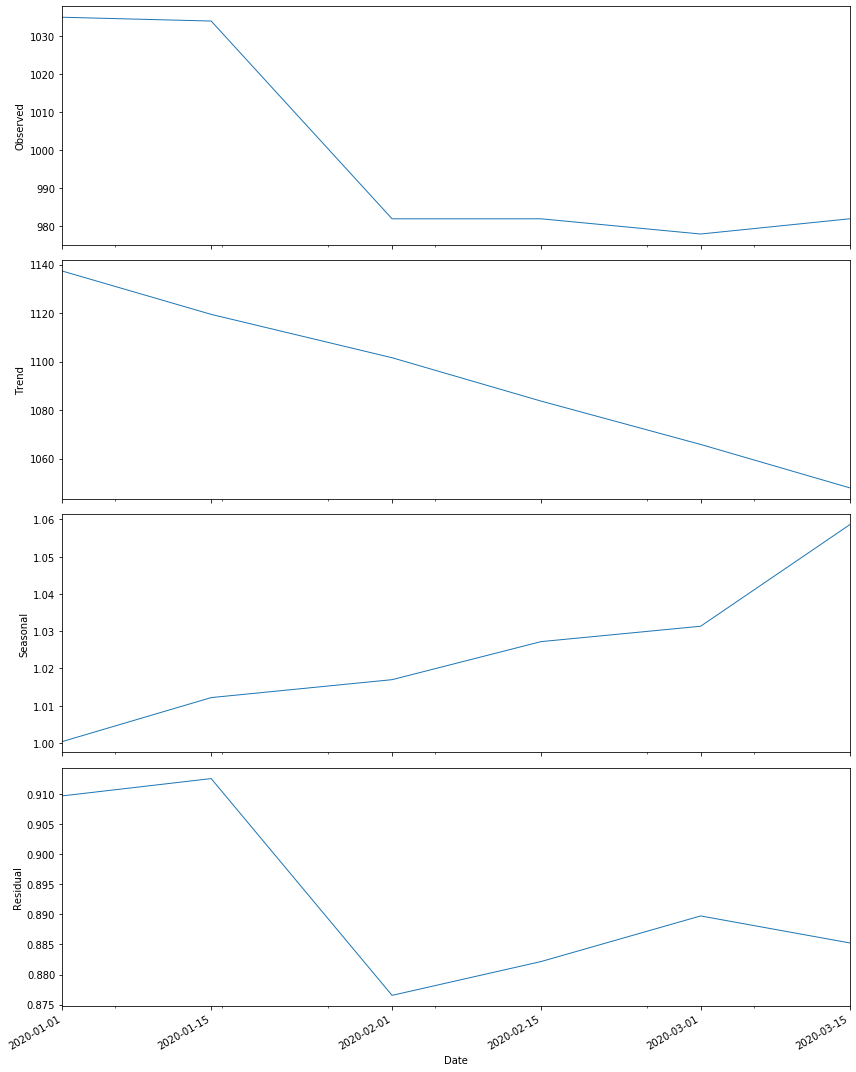

Last 2 observations:


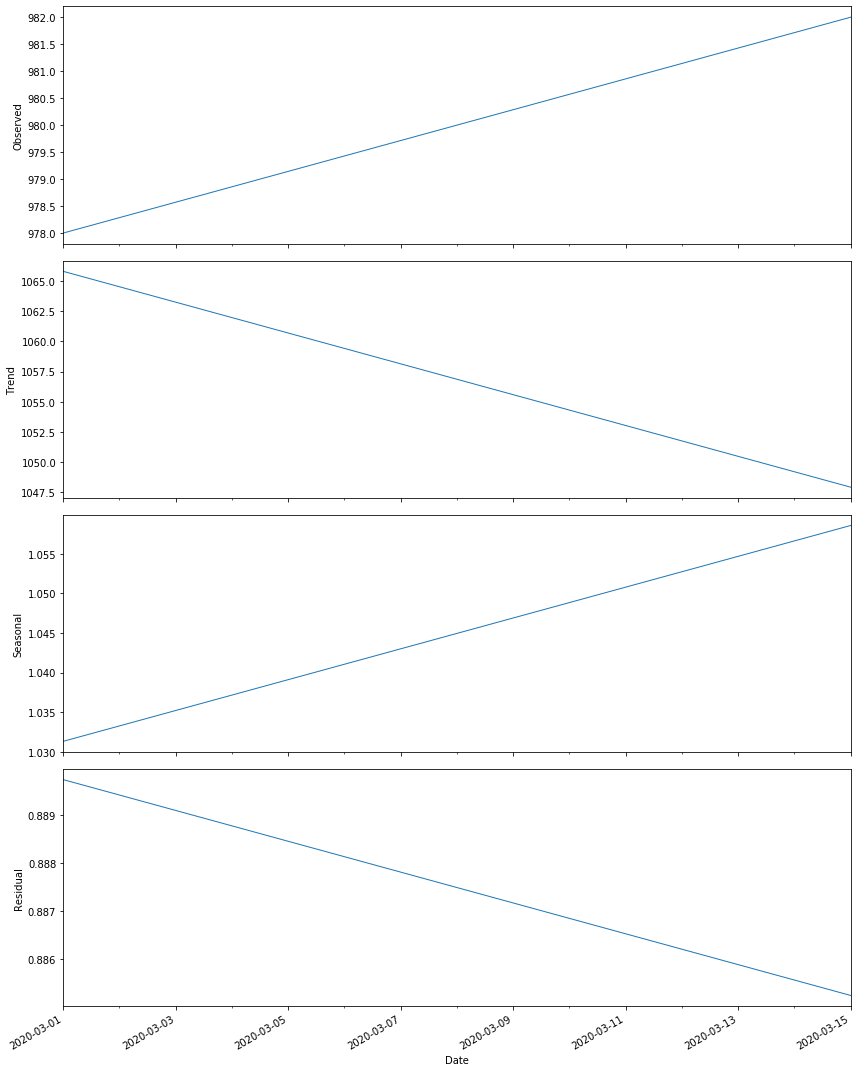


##### Time Series Decomposition for CatABids #####


Time Series Decomposition (Multiplicative) for 433 observations:


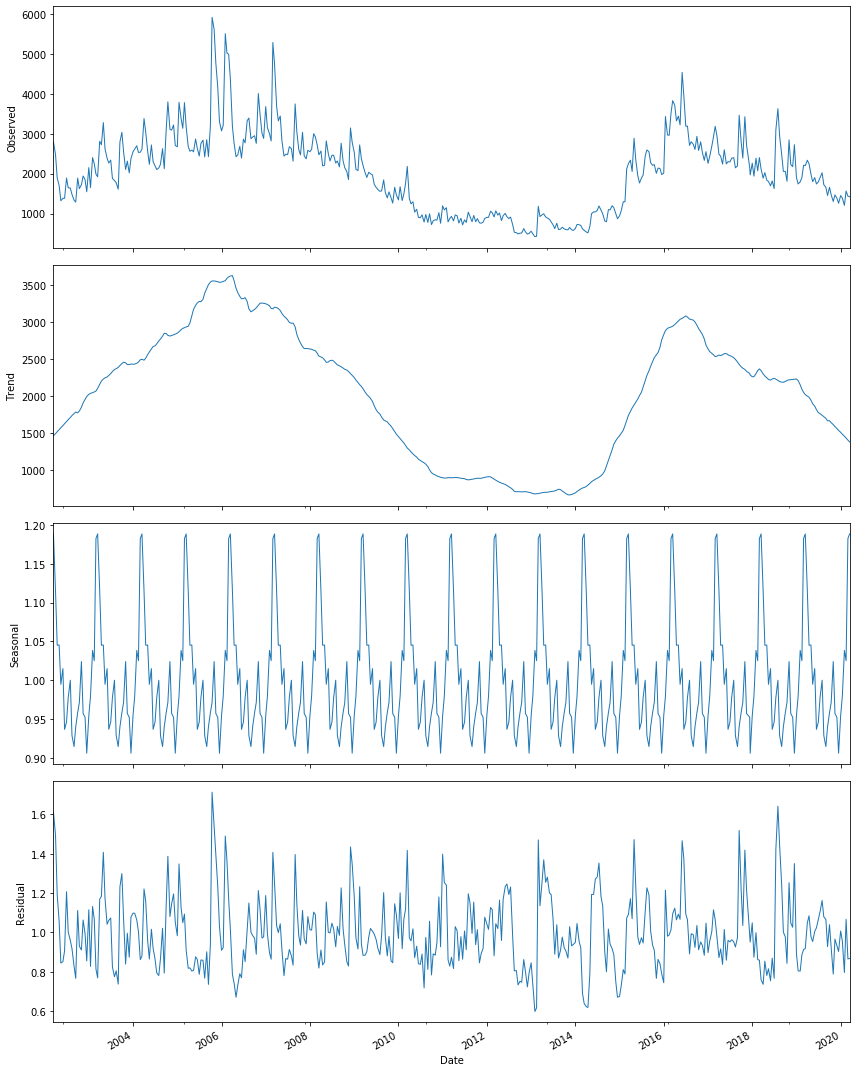

Last 24 observations:


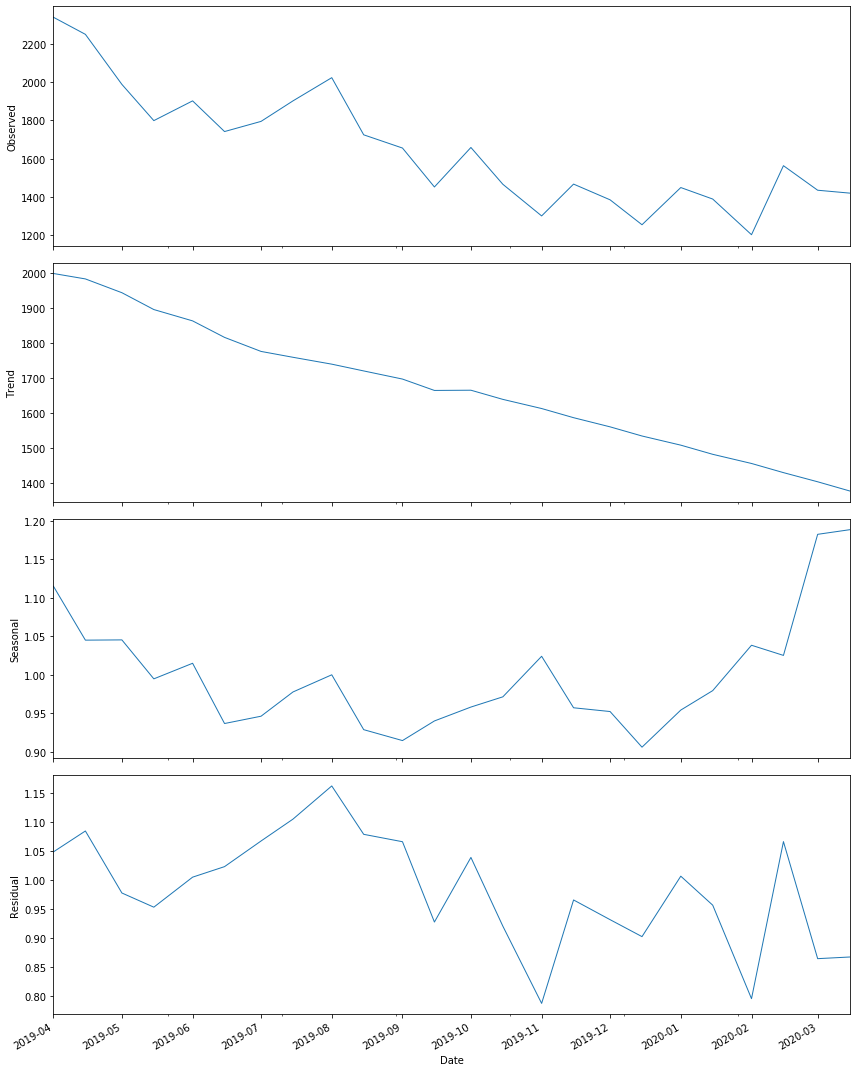

Last 6 observations:


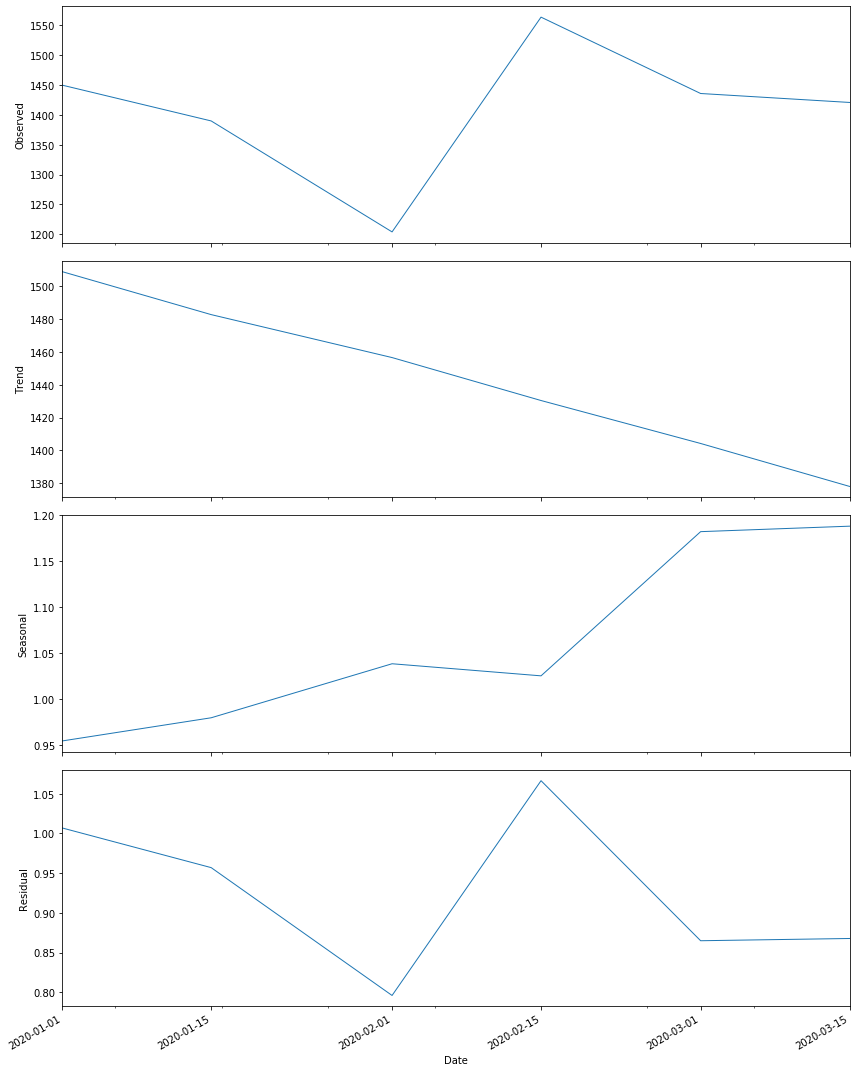

Last 2 observations:


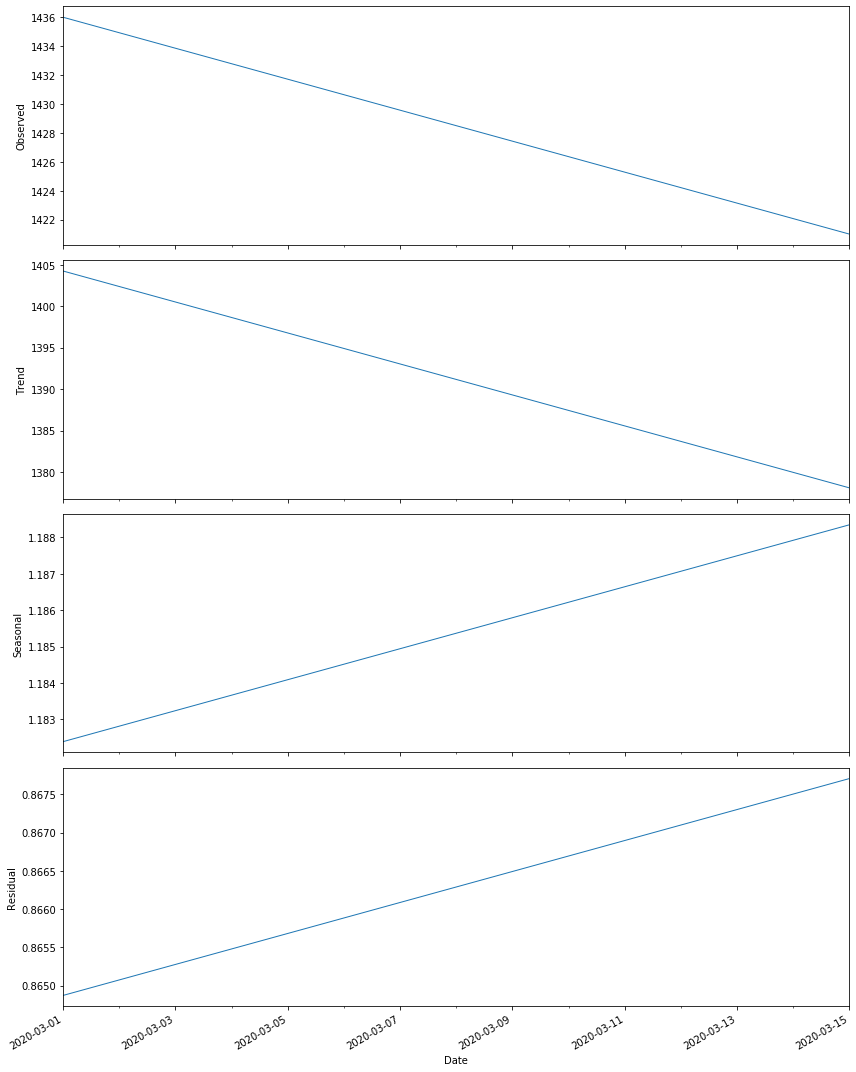


##### Time Series Decomposition for CatBCOE #####


Time Series Decomposition (Multiplicative) for 433 observations:


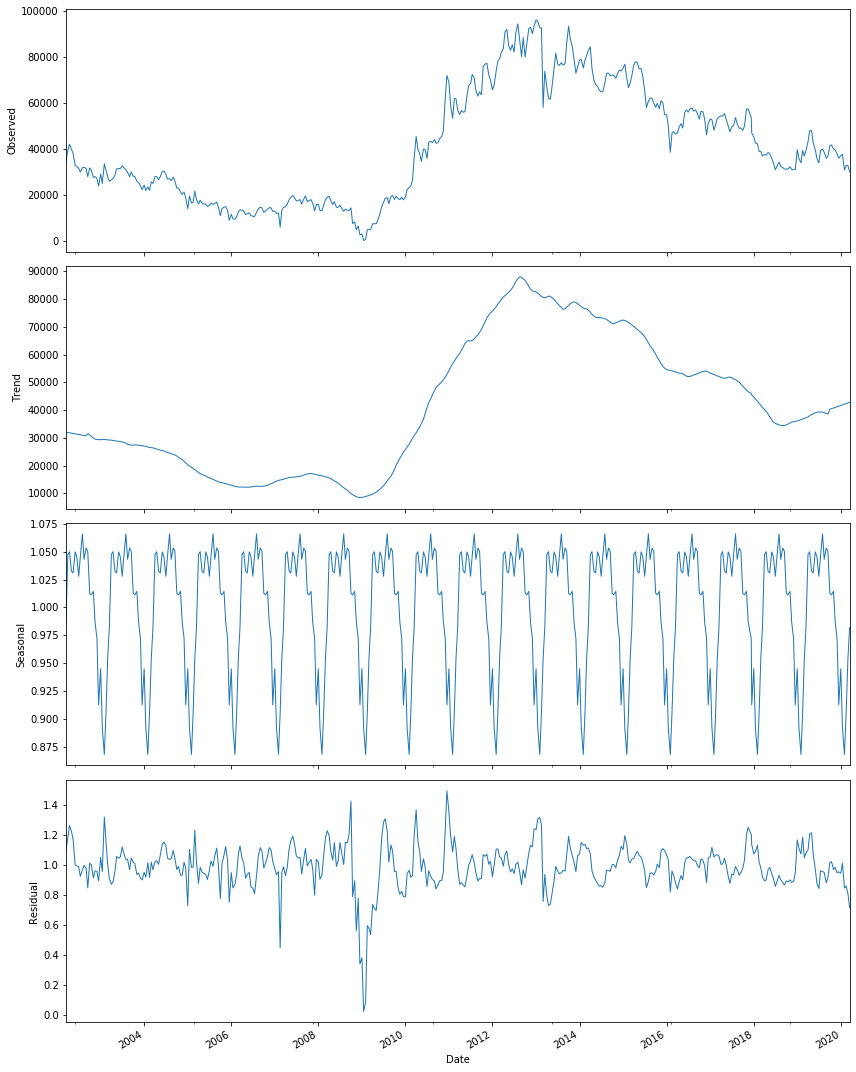

Last 24 observations:


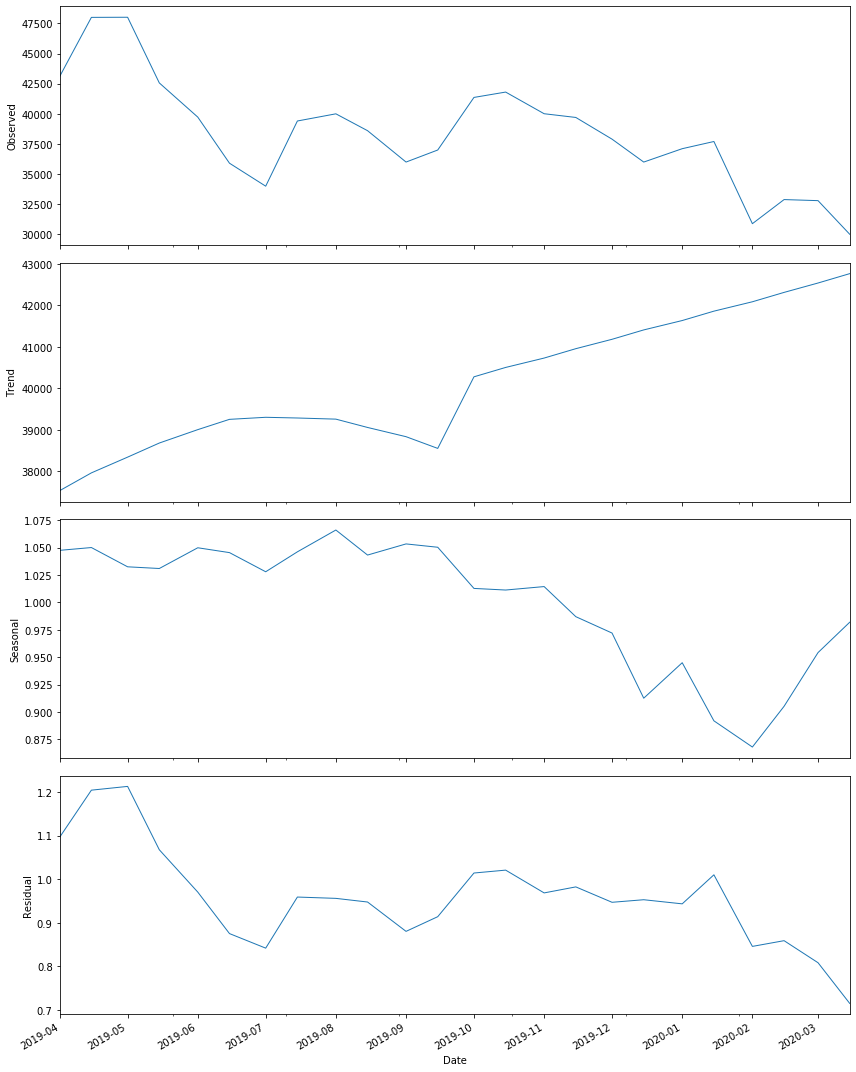

Last 6 observations:


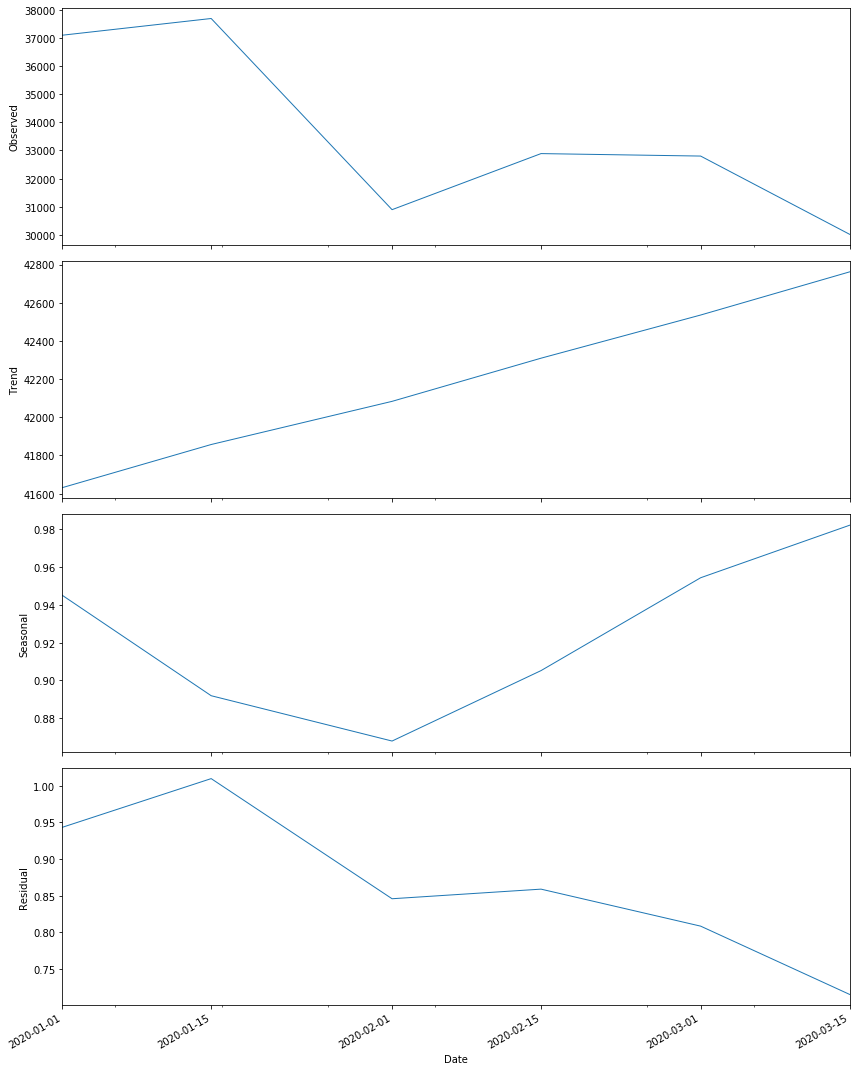

Last 2 observations:


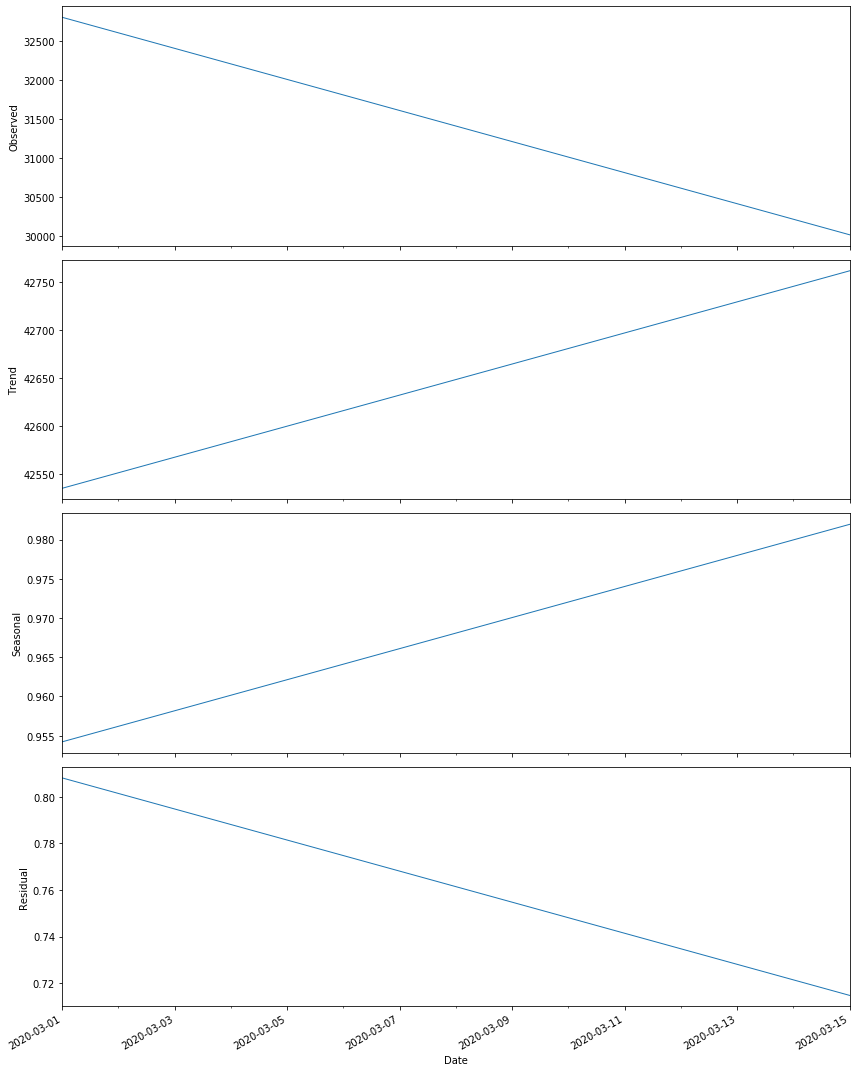


##### Time Series Decomposition for CatBQuota #####


Time Series Decomposition (Multiplicative) for 433 observations:


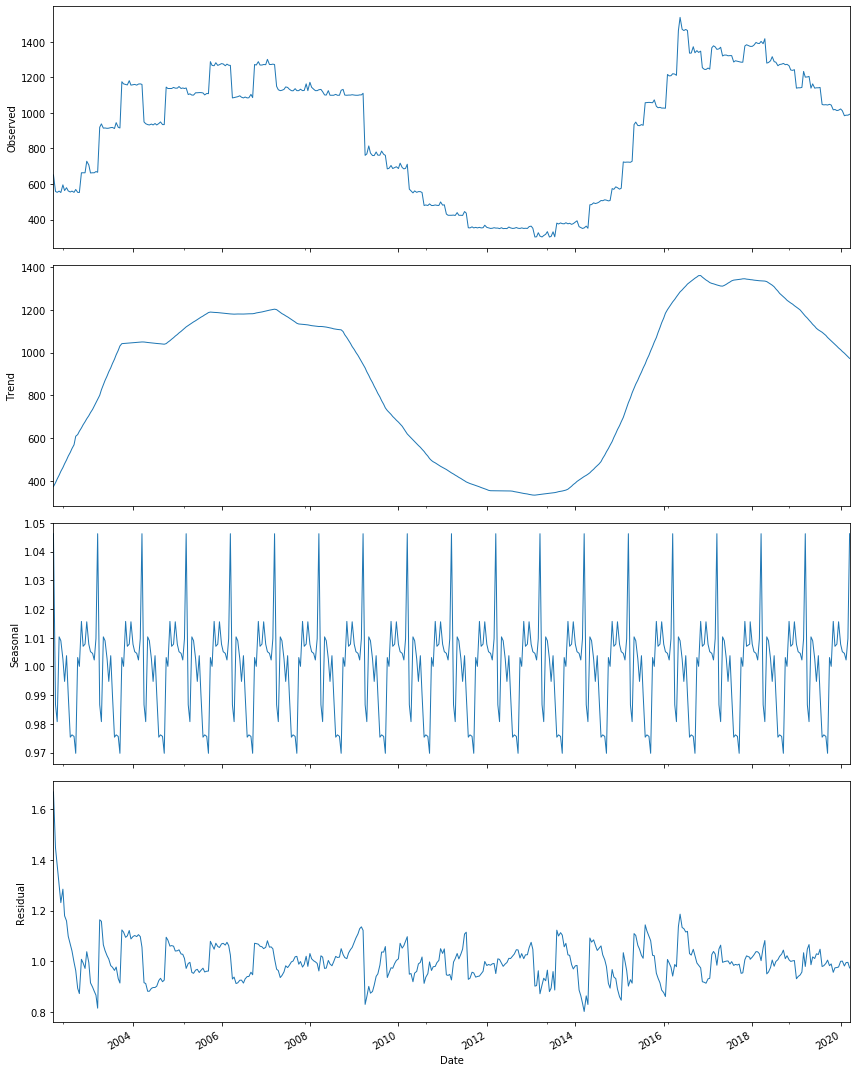

Last 24 observations:


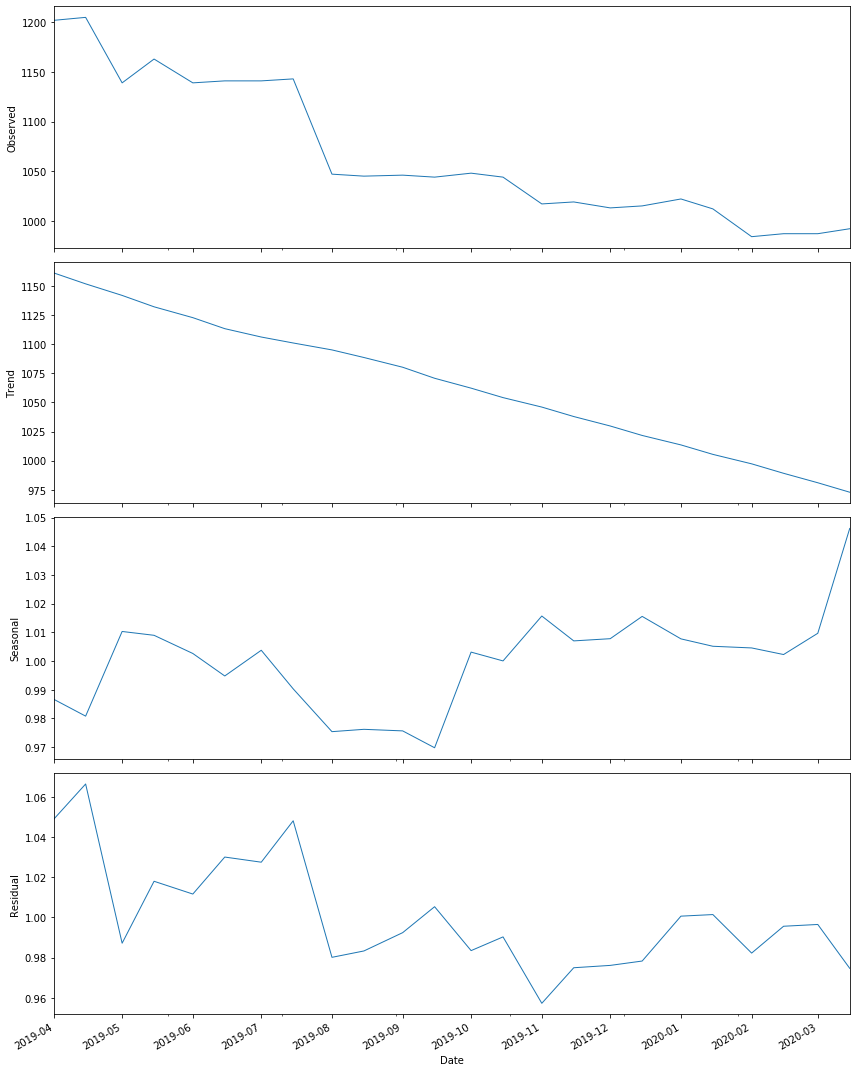

Last 6 observations:


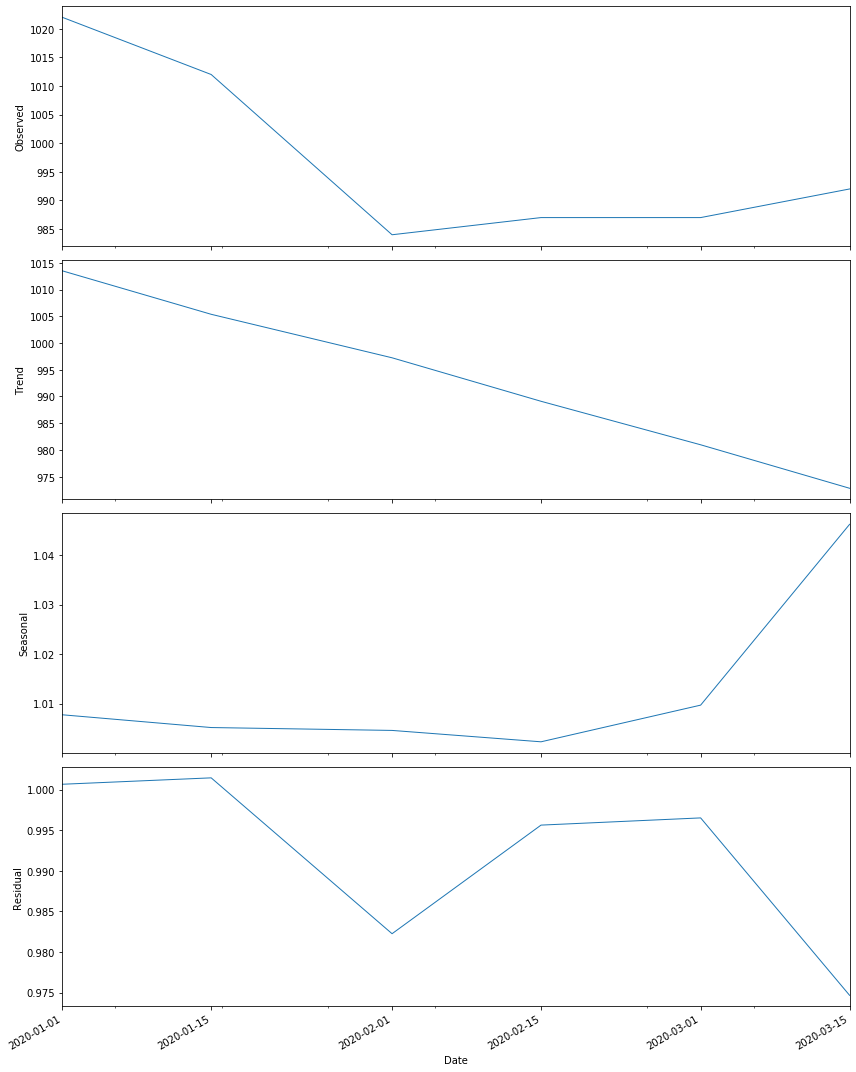

Last 2 observations:


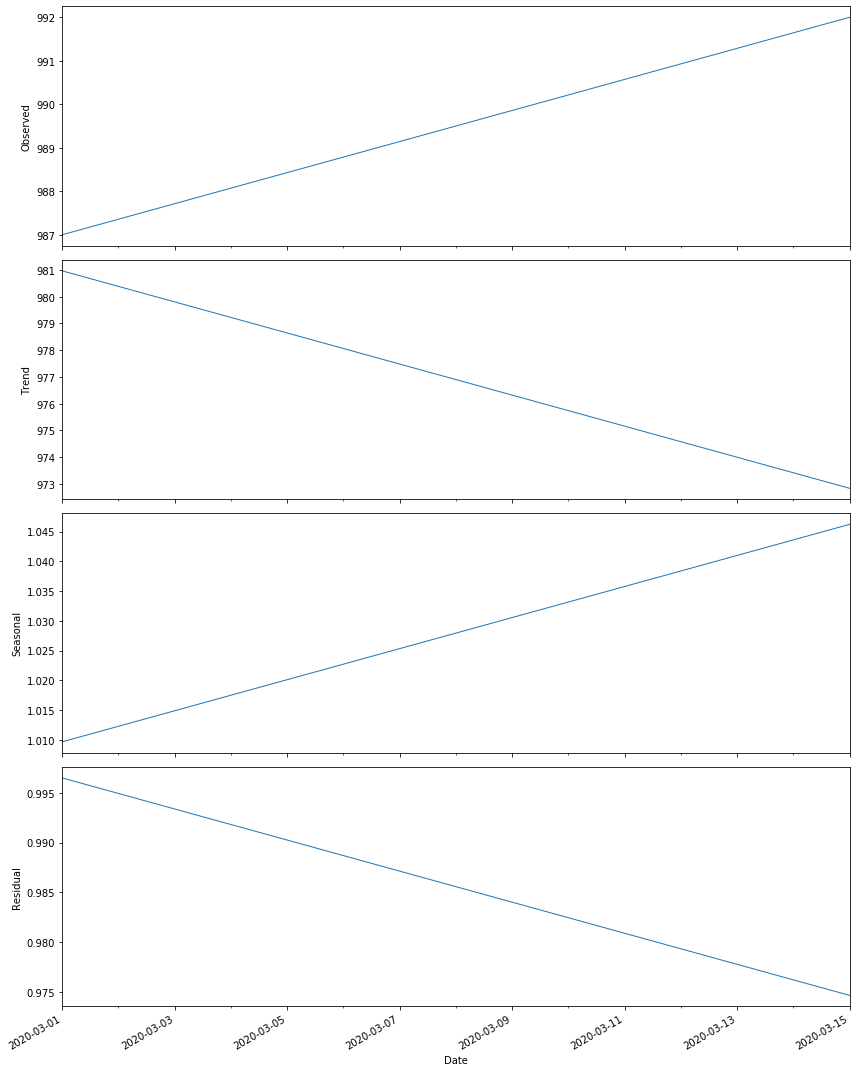


##### Time Series Decomposition for CatBBids #####


Time Series Decomposition (Multiplicative) for 433 observations:


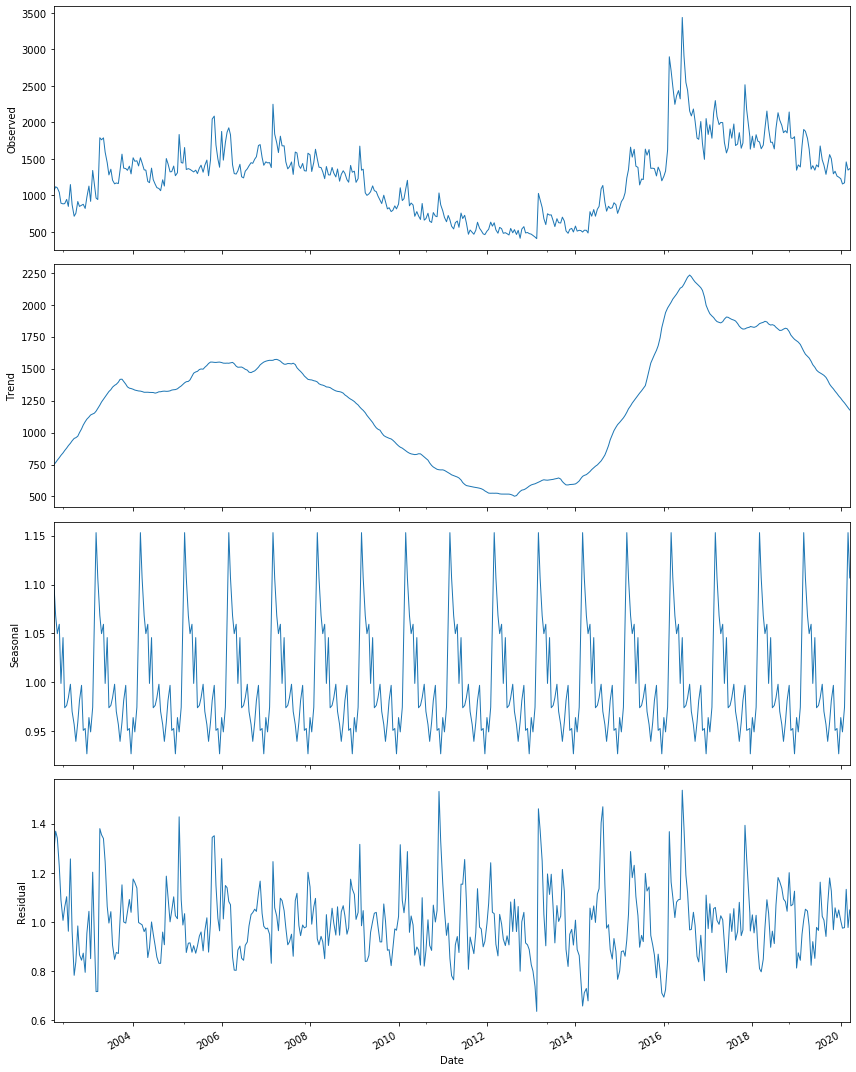

Last 24 observations:


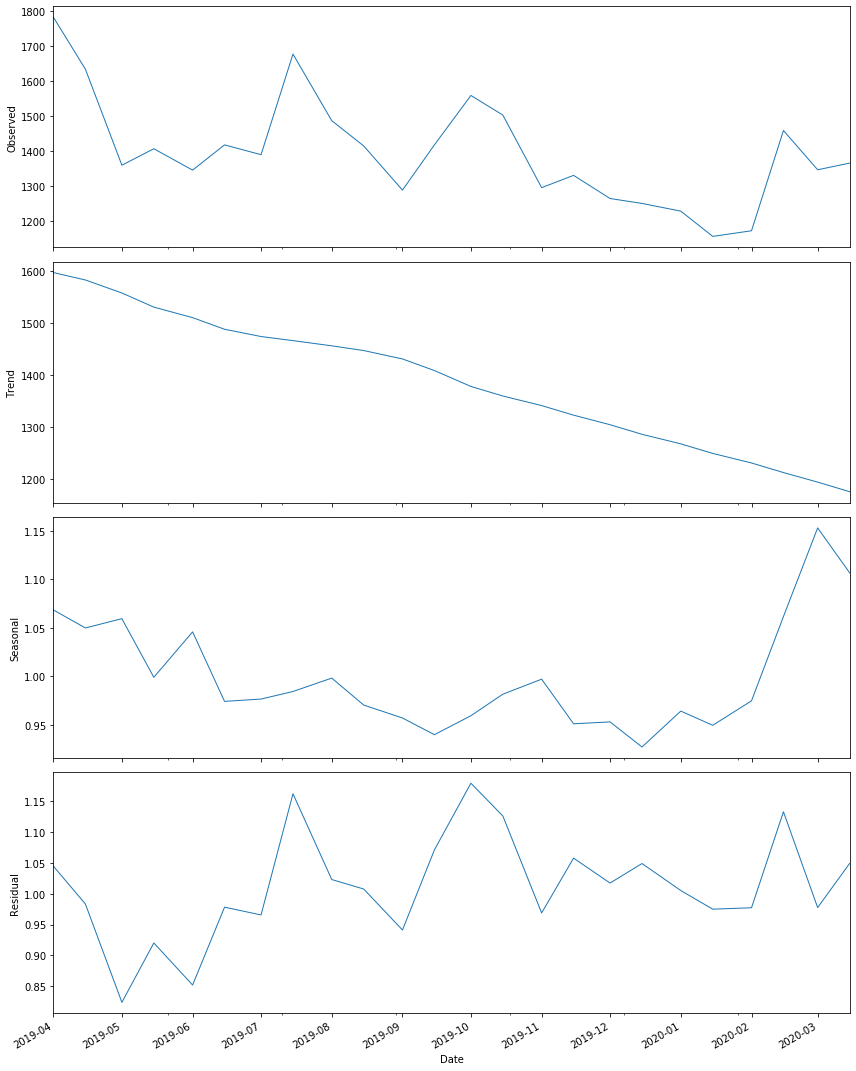

Last 6 observations:


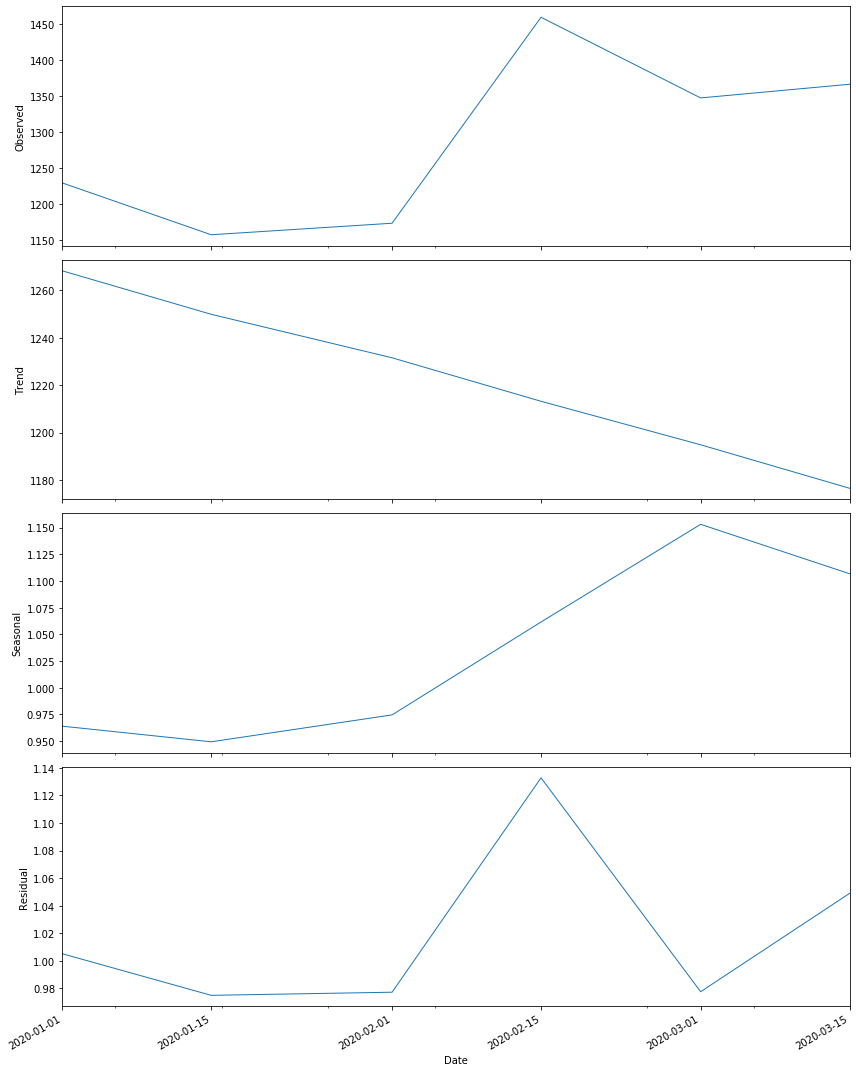

Last 2 observations:


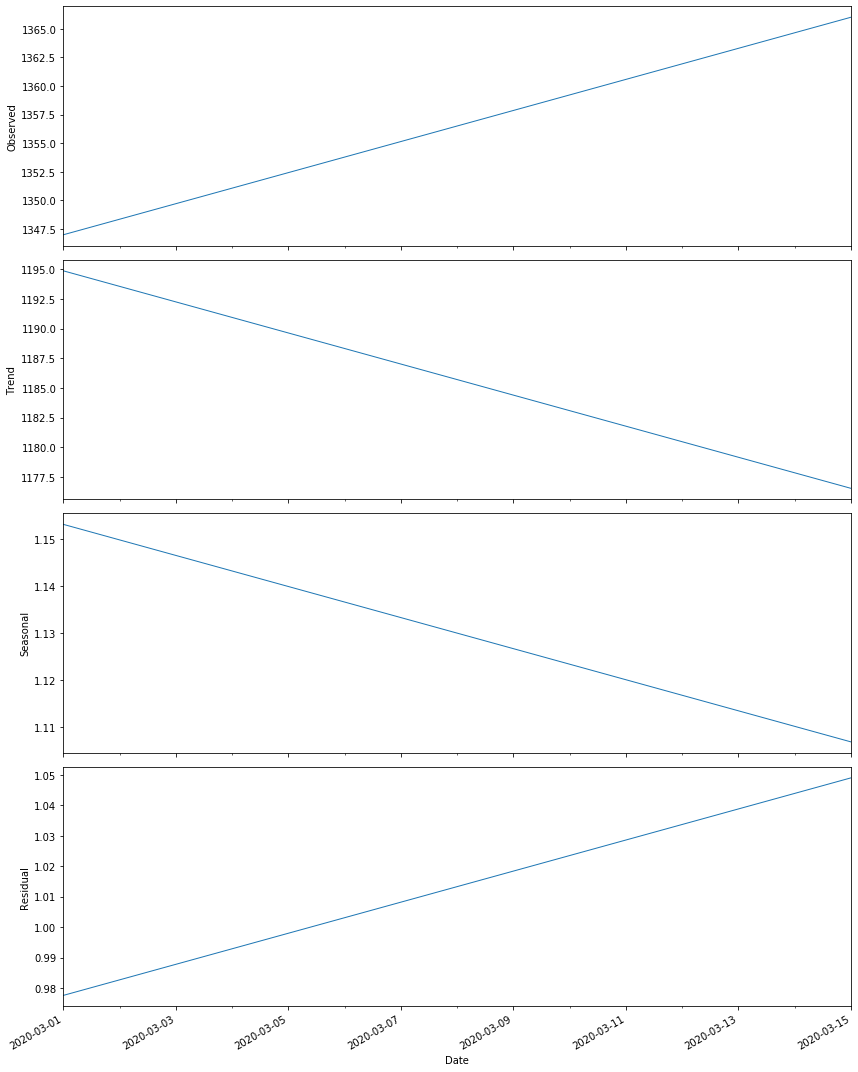


##### Time Series Decomposition for CatEQuota #####


Time Series Decomposition (Multiplicative) for 433 observations:


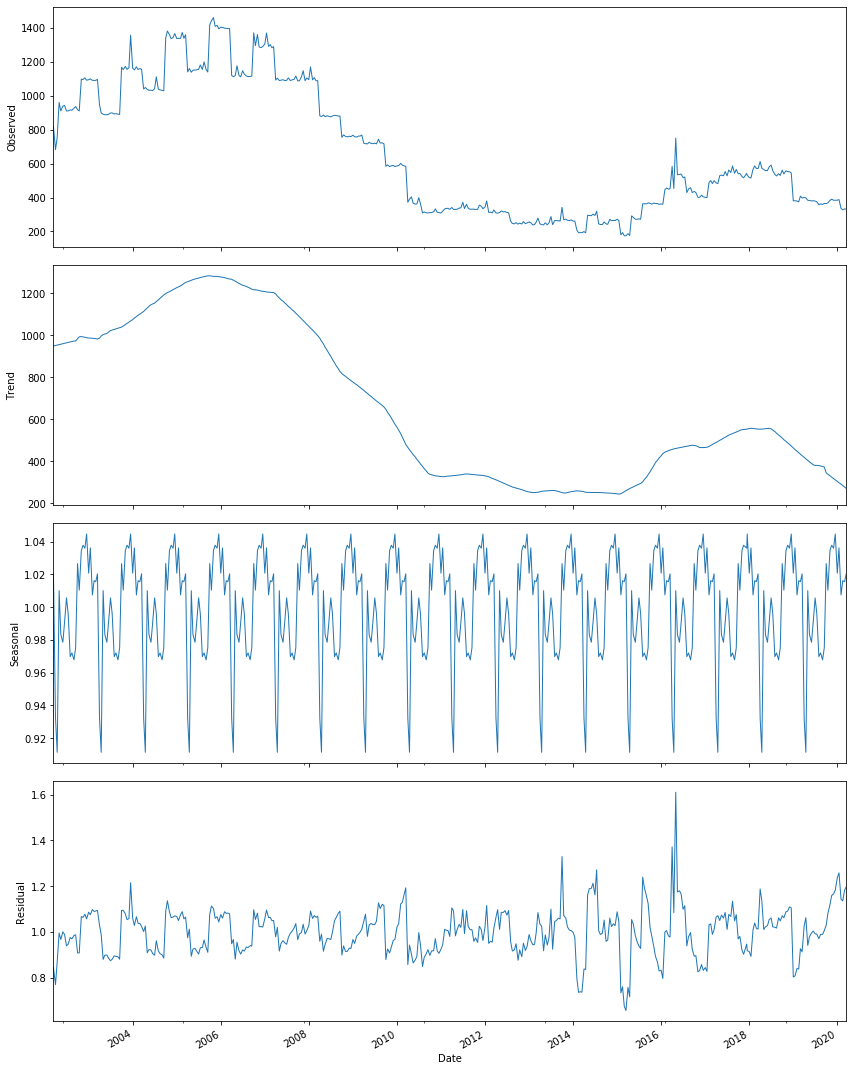

Last 24 observations:


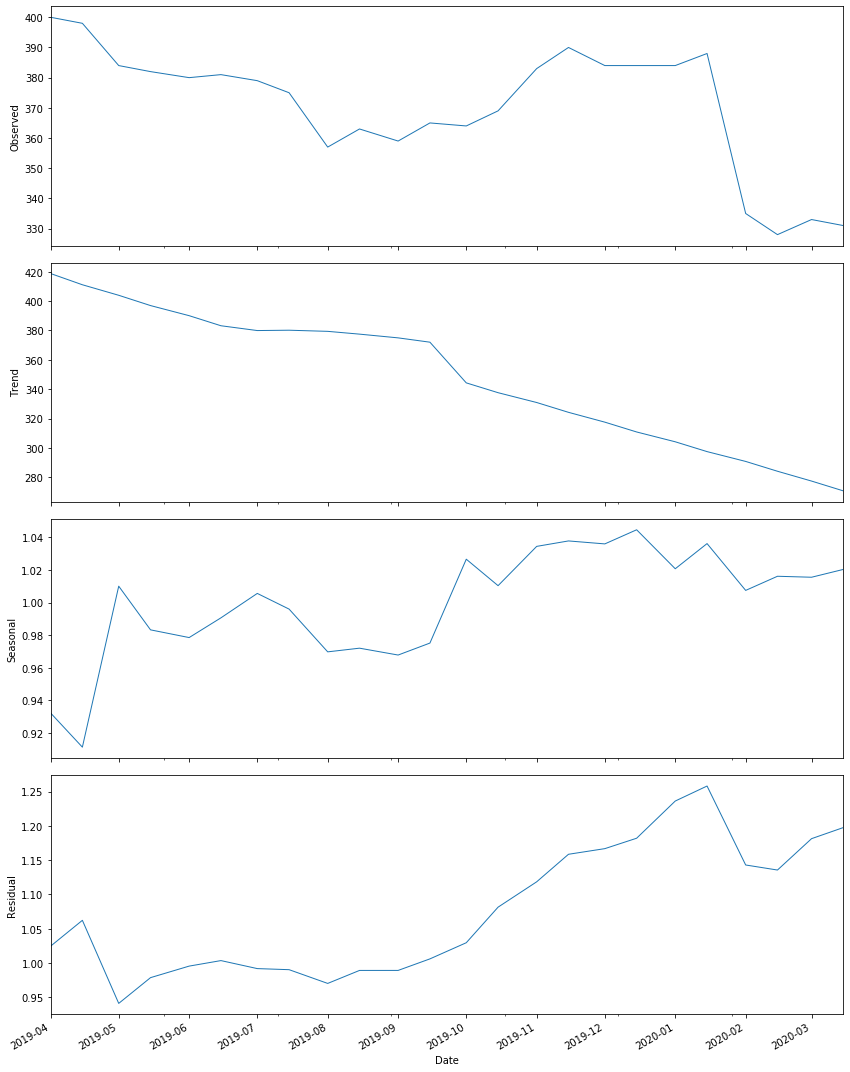

Last 6 observations:


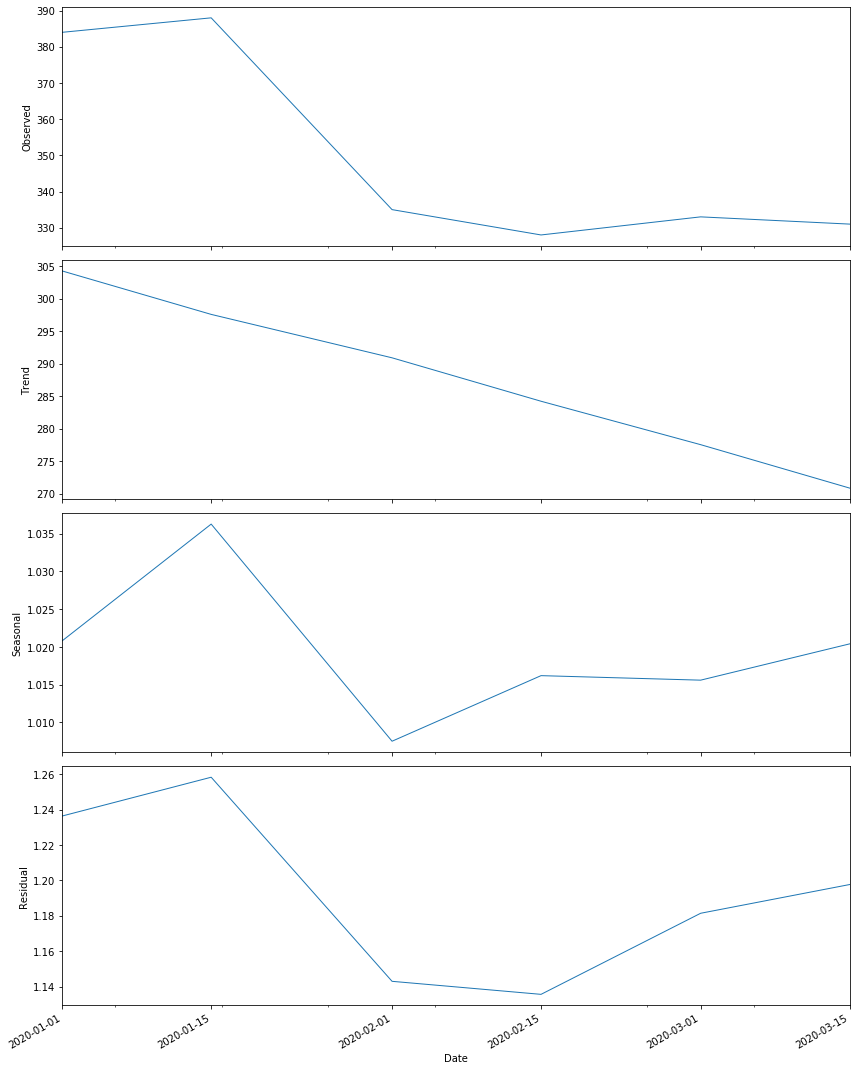

Last 2 observations:


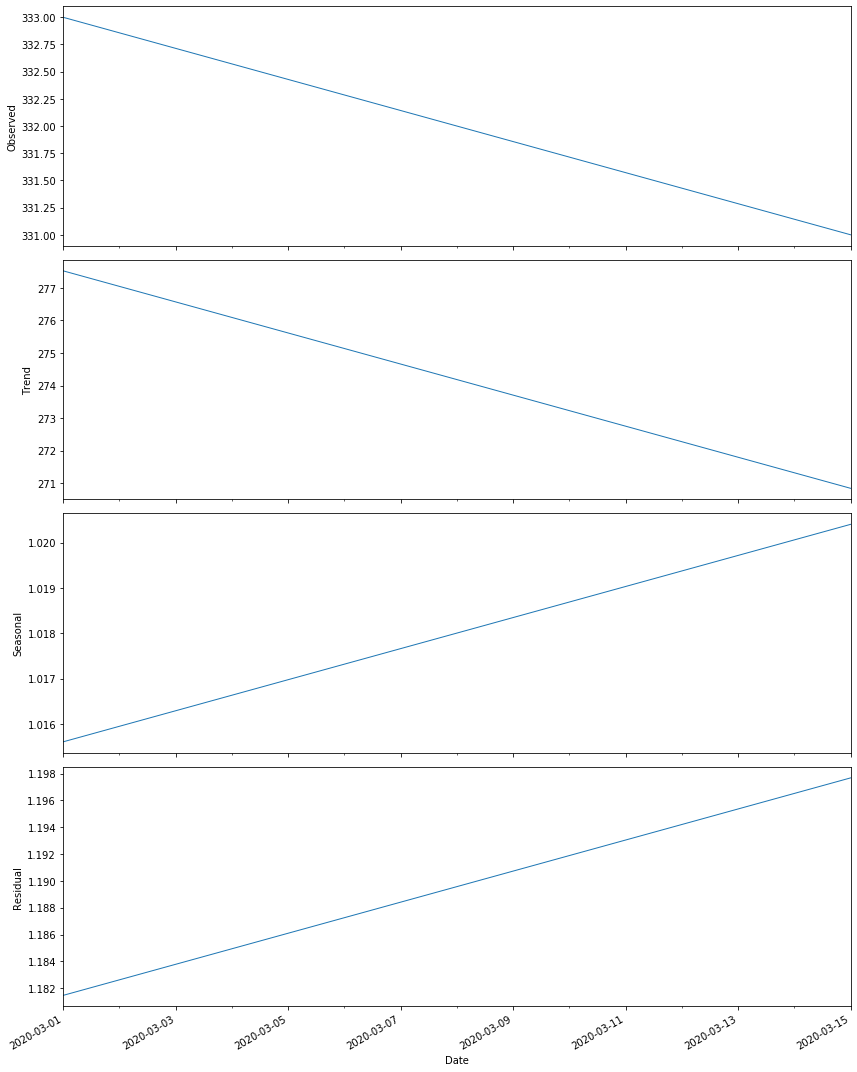


##### Time Series Decomposition for CatEBids #####


Time Series Decomposition (Multiplicative) for 433 observations:


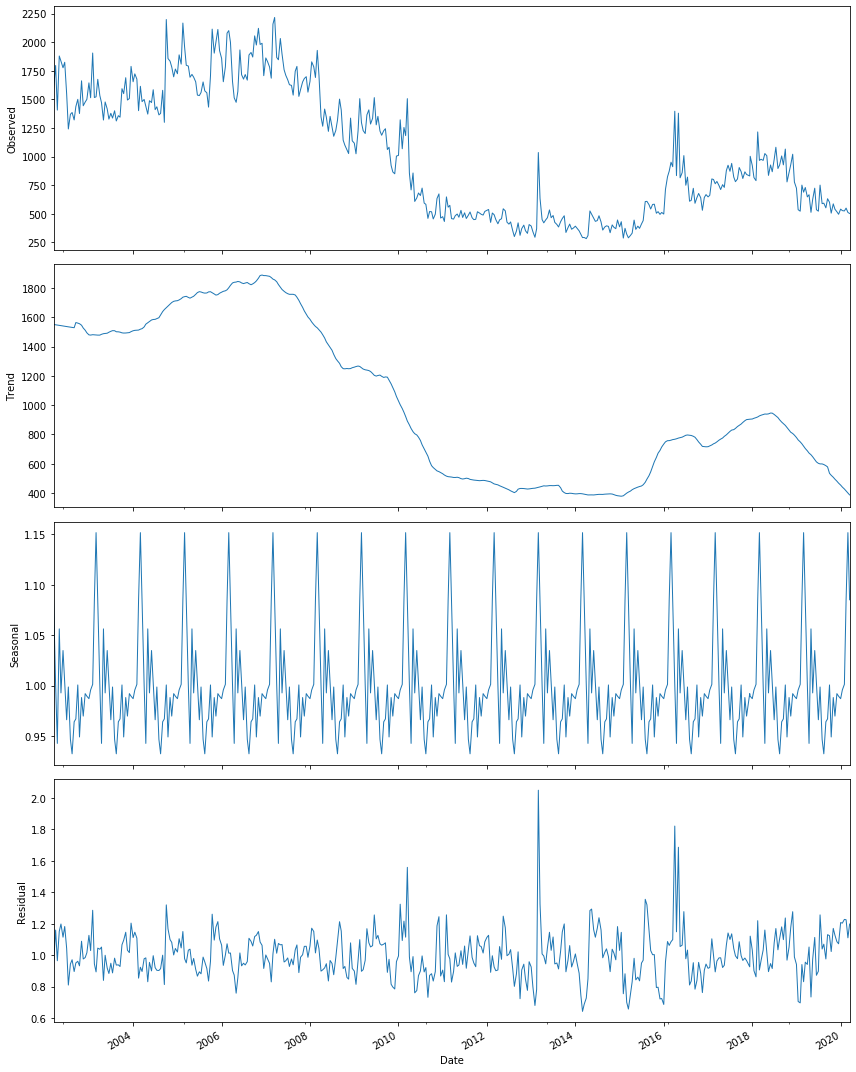

Last 24 observations:


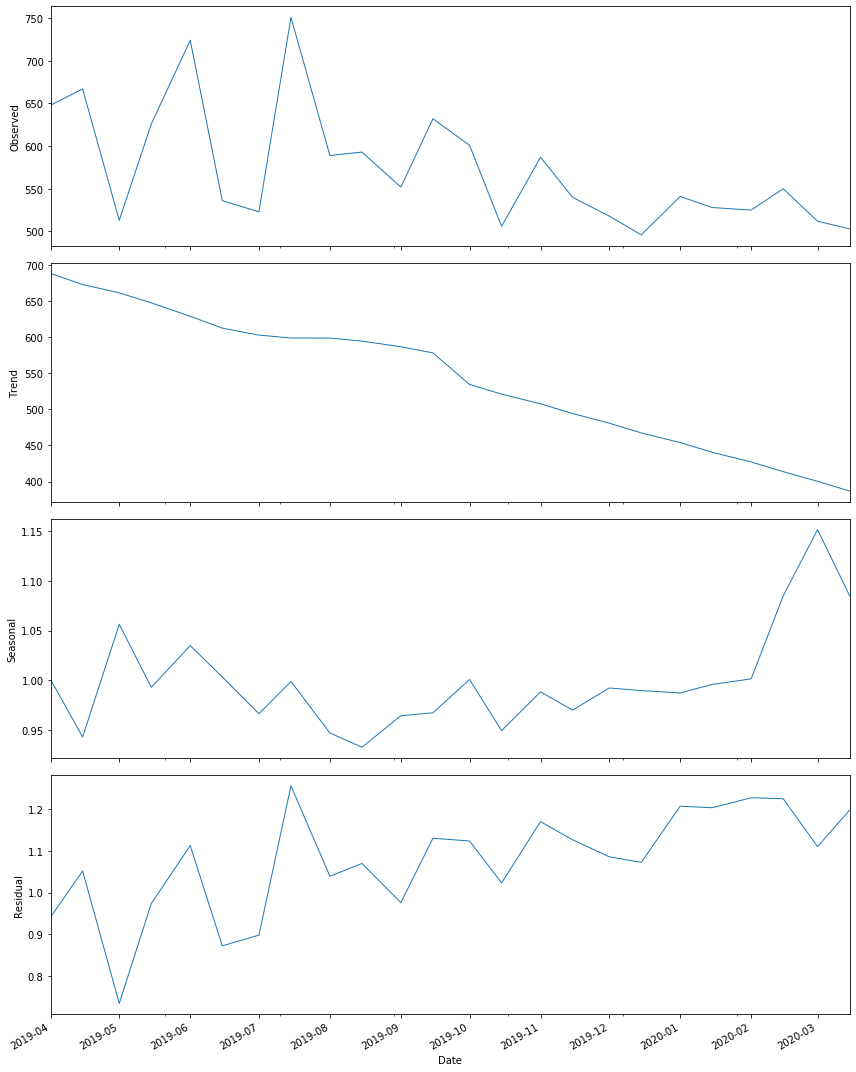

Last 6 observations:


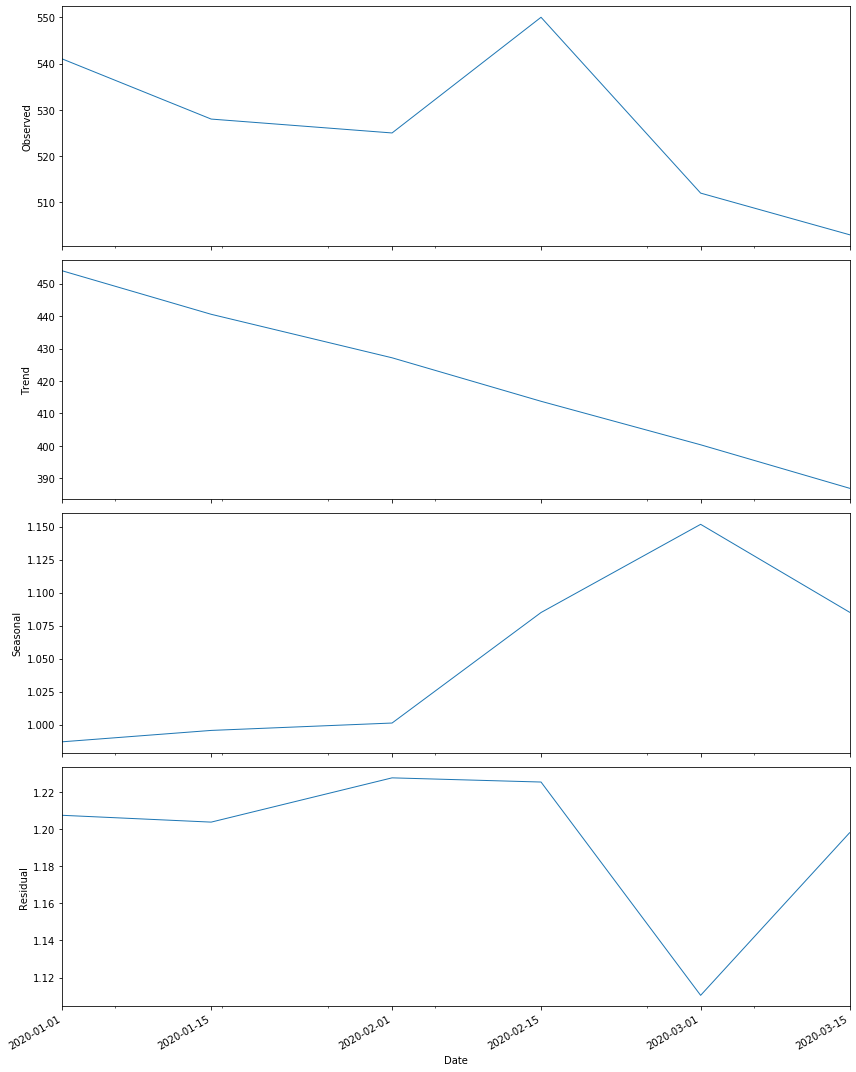

Last 2 observations:


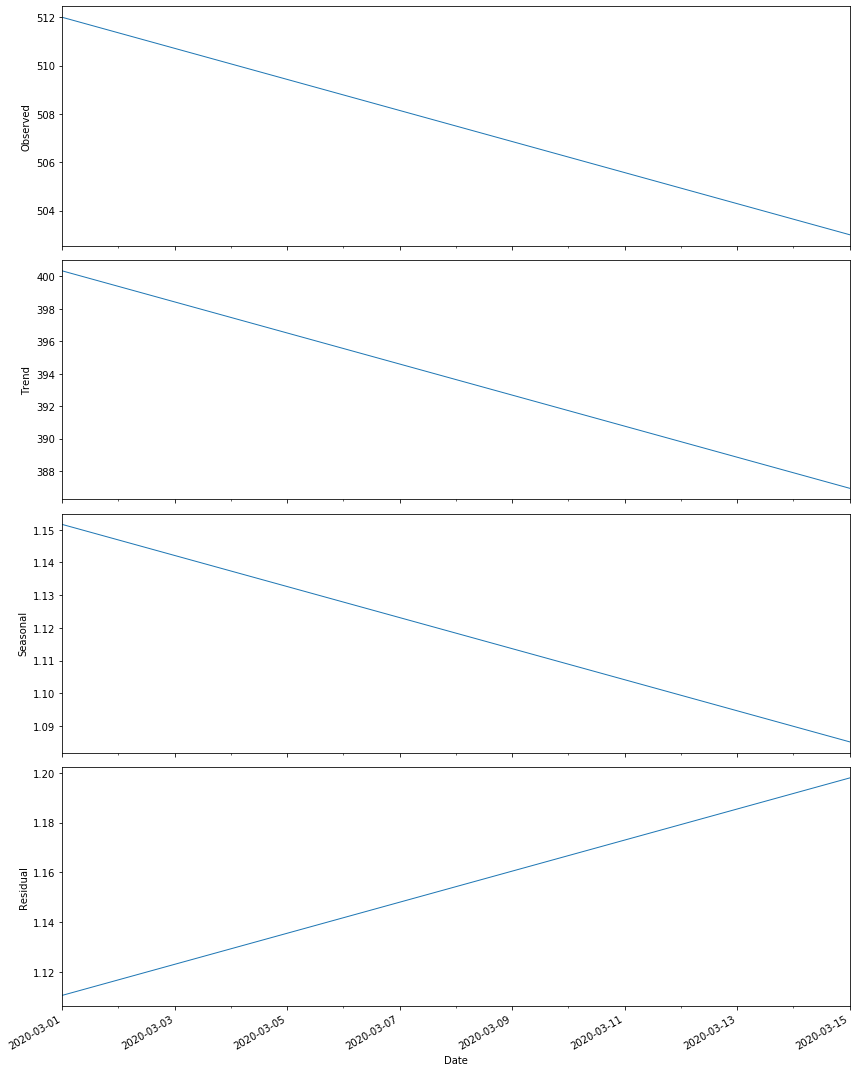

In [7]:
for var in list(df.columns[1:]):
    print("\n##### Time Series Decomposition for",var,"#####\n")
    ts_decomp(df[var], model_type='mul', freq=24)

### Auto ARIMA Selection

#### Forecasting Exogenous Variables

In [8]:
from pmdarima.arima import auto_arima
import sys
if not sys.warnoptions:
    import warnings
    #suppress warning messages (those with peach background)
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings("ignore", category=DeprecationWarning) 

exog_data = df.drop(columns=['CatECOE'],inplace=False).copy()
exog_forecast = pd.DataFrame()

for var in list(exog_data.columns):
    data = exog_data[var].dropna(inplace=False).copy()
    
    exog_predict = auto_arima(data,
                              start_p=0, max_p=7, 
                              start_q=0, max_q=7, 
                              max_d=3, max_order=16,
                              seasonal=True, m=24,
                              stationary=False,
                              transparams=True,
                              information_criterion='aic',
                              out_of_sample_size=24,
                              trace=True,
                              stepwise=True,
                              suppress_warnings=True,
                              scoring='mse')
    
    results = exog_predict.predict(n_periods=4)
    exog_forecast[var] = results
    
forecast_date = pd.date_range(start='04/01/2020',end='05/31/2020',freq='SMS')
exog_forecast.set_index(forecast_date, inplace=True)

exog_data = pd.concat([exog_data,exog_forecast],axis=0)
exog_data

C:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 24); AIC=8155.550, BIC=8171.823, Fit time=2.870 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=8154.062, BIC=8162.199, Fit time=0.074 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=8156.042, BIC=8172.316, Fit time=1.055 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=8155.846, BIC=8172.120, Fit time=1.108 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=8155.694, BIC=8167.899, Fit time=0.869 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 24); AIC=8155.700, BIC=8167.906, Fit time=1.035 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=8154.421, BIC=8166.626, Fit time=0.196 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 24); AIC=8154.225, BIC=8166.430, Fit time=0.208 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 24); AIC=8151.036, BIC=8167.309, Fit time=0.604 seconds
Fit ARIMA: order=(1, 1, 1) s

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=4501.990, BIC=4518.264, Fit time=2.321 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=4510.112, BIC=4526.386, Fit time=2.336 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 24); AIC=4508.690, BIC=4520.896, Fit time=1.793 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=4496.395, BIC=4516.737, Fit time=12.511 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=4494.530, BIC=4510.804, Fit time=9.527 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=4496.079, BIC=4516.422, Fit time=14.571 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 0, 24); AIC=4495.863, BIC=4516.205, Fit time=10.986 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 24); AIC=4496.980, BIC=4521.390, Fit time=20.838 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=4500.439, BIC=4512.644, Fit time=2.391 seconds
Total fit time: 80.048 s

CatACOE    CatAQuota     CatABids       CatBCOE   CatBQuota  \
2002-03-15  33201.000000  1468.000000  2800.000000  34200.000000  651.000000   
2002-04-01  37201.000000  1110.000000  2484.000000  39509.000000  558.000000   
2002-04-15  36000.000000  1149.000000  1890.000000  42101.000000  553.000000   
2002-05-01  35000.000000  1128.000000  1705.000000  40001.000000  560.000000   
2002-05-15  33401.000000  1111.000000  1320.000000  38001.000000  552.000000   
...                  ...          ...          ...           ...         ...   
2020-03-15  31210.000000   982.000000  1421.000000  30012.000000  992.000000   
2020-04-01  31567.474918   984.620458  1469.634847  30856.827878  991.091676   
2020-04-15  31876.105700   983.956130  1472.066618  31705.120633  996.176944   
2020-05-01  32088.322202   887.623330  1448.898680  32453.428921  962.907191   
2020-05-15  32170.291477   907.431192  1429.609353  33016.239674  969.526946   

               CatBBids   CatEQuota     CatEBids  
2002-03-15  1052.000000  817.000000  1594.000000  
2002-04-01  1119.000000  682.000000  1797.000000  
2002-04-15  1104.000000  754.000000  1407.000000  
2002-05-01  1043.000000  960.000000  1880.000000  
2002-05-15   894.000000  910.000000  1835.000000  
...                 ...         ...          ...  
2020-03-15  1366.000000  331.000000   503.000000  
2020-04-01  1355.576065  335.842470   502.385973  
2020-04-15  1340.608768  332.532723   505.249668  
2020-05-01  1315.218123  308.758584   483.312217  
2020-05-15  1322.201293  315.528748   498.535855  

[437 rows x 8 columns]

In [9]:
# Creating lagged variables
df = pd.concat([df['CatECOE'],exog_data], axis=1, join='outer')

df_lagged = pd.DataFrame()

for item in list(df.columns[:]):
    for i in [1, 2, 3, 24]:
        key = item + '-' + str(i)
        df_lagged[key] = df[item].shift(i)

df_lagged = df_lagged[24:]

df = df[24:]
df = pd.concat([df,df_lagged],axis=1)
df

CatECOE       CatACOE    CatAQuota     CatABids       CatBCOE  \
2003-03-15  25501.0  26999.000000  1337.000000  1923.000000  26001.000000   
2003-04-01  27501.0  27497.000000  1473.000000  2816.000000  26601.000000   
2003-04-15  28109.0  28054.000000  1474.000000  2728.000000  27058.000000   
2003-05-01  29538.0  29299.000000  1479.000000  3284.000000  28589.000000   
2003-05-15  31800.0  31095.000000  1471.000000  2621.000000  31400.000000   
...             ...           ...          ...          ...           ...   
2020-03-15  32500.0  31210.000000   982.000000  1421.000000  30012.000000   
2020-04-01      NaN  31567.474918   984.620458  1469.634847  30856.827878   
2020-04-15      NaN  31876.105700   983.956130  1472.066618  31705.120633   
2020-05-01      NaN  32088.322202   887.623330  1448.898680  32453.428921   
2020-05-15      NaN  32170.291477   907.431192  1429.609353  33016.239674   

             CatBQuota     CatBBids    CatEQuota     CatEBids  CatECOE-1  ...  \
2003-03-15  666.000000   944.000000  1096.000000  1676.000000    27000.0  ...   
2003-04-01  919.000000  1790.000000   946.000000  1535.000000    25501.0  ...   
2003-04-15  938.000000  1762.000000   898.000000  1471.000000    27501.0  ...   
2003-05-01  914.000000  1788.000000   891.000000  1320.000000    28109.0  ...   
2003-05-15  915.000000  1592.000000   888.000000  1478.000000    29538.0  ...   
...                ...          ...          ...          ...        ...  ...   
2020-03-15  992.000000  1366.000000   331.000000   503.000000    32500.0  ...   
2020-04-01  991.091676  1355.576065   335.842470   502.385973    32500.0  ...   
2020-04-15  996.176944  1340.608768   332.532723   505.249668        NaN  ...   
2020-05-01  962.907191  1315.218123   308.758584   483.312217        NaN  ...   
2020-05-15  969.526946  1322.201293   315.528748   498.535855        NaN  ...   

             CatBBids-3  CatBBids-24  CatEQuota-1  CatEQuota-2  CatEQuota-3  \
2003-03-15  1342.000000       1052.0  1090.000000  1090.000000   1090.00000   
2003-04-01  1148.000000       1119.0  1096.000000  1090.000000   1090.00000   
2003-04-15   965.000000       1104.0   946.000000  1096.000000   1090.00000   
2003-05-01   944.000000       1043.0   898.000000   946.000000   1096.00000   
2003-05-15  1790.000000        894.0   891.000000   898.000000    946.00000   
...                 ...          ...          ...          ...          ...   
2020-03-15  1173.000000       1878.0   333.000000   328.000000    335.00000   
2020-04-01  1459.000000       1782.0   331.000000   333.000000    328.00000   
2020-04-15  1347.000000       1634.0   335.842470   331.000000    333.00000   
2020-05-01  1366.000000       1360.0   332.532723   335.842470    331.00000   
2020-05-15  1355.576065       1407.0   308.758584   332.532723    335.84247   

            CatEQuota-24   CatEBids-1   CatEBids-2   CatEBids-3  CatEBids-24  
2003-03-15         817.0  1523.000000  1517.000000  1906.000000       1594.0  
2003-04-01         682.0  1676.000000  1523.000000  1517.000000       1797.0  
2003-04-15         754.0  1535.000000  1676.000000  1523.000000       1407.0  
2003-05-01         960.0  1471.000000  1535.000000  1676.000000       1880.0  
2003-05-15         910.0  1320.000000  1471.000000  1535.000000       1835.0  
...                  ...          ...          ...          ...          ...  
2020-03-15         397.0   512.000000   550.000000   525.000000        730.0  
2020-04-01         400.0   503.000000   512.000000   550.000000        648.0  
2020-04-15         398.0   502.385973   503.000000   512.000000        667.0  
2020-05-01         384.0   505.249668   502.385973   503.000000        513.0  
2020-05-15         382.0   483.312217   505.249668   502.385973        626.0  

[413 rows x 45 columns]

In [10]:
exog_data = df.copy()
exog_data

CatECOE       CatACOE    CatAQuota     CatABids       CatBCOE  \
2003-03-15  25501.0  26999.000000  1337.000000  1923.000000  26001.000000   
2003-04-01  27501.0  27497.000000  1473.000000  2816.000000  26601.000000   
2003-04-15  28109.0  28054.000000  1474.000000  2728.000000  27058.000000   
2003-05-01  29538.0  29299.000000  1479.000000  3284.000000  28589.000000   
2003-05-15  31800.0  31095.000000  1471.000000  2621.000000  31400.000000   
...             ...           ...          ...          ...           ...   
2020-03-15  32500.0  31210.000000   982.000000  1421.000000  30012.000000   
2020-04-01      NaN  31567.474918   984.620458  1469.634847  30856.827878   
2020-04-15      NaN  31876.105700   983.956130  1472.066618  31705.120633   
2020-05-01      NaN  32088.322202   887.623330  1448.898680  32453.428921   
2020-05-15      NaN  32170.291477   907.431192  1429.609353  33016.239674   

             CatBQuota     CatBBids    CatEQuota     CatEBids  CatECOE-1  ...  \
2003-03-15  666.000000   944.000000  1096.000000  1676.000000    27000.0  ...   
2003-04-01  919.000000  1790.000000   946.000000  1535.000000    25501.0  ...   
2003-04-15  938.000000  1762.000000   898.000000  1471.000000    27501.0  ...   
2003-05-01  914.000000  1788.000000   891.000000  1320.000000    28109.0  ...   
2003-05-15  915.000000  1592.000000   888.000000  1478.000000    29538.0  ...   
...                ...          ...          ...          ...        ...  ...   
2020-03-15  992.000000  1366.000000   331.000000   503.000000    32500.0  ...   
2020-04-01  991.091676  1355.576065   335.842470   502.385973    32500.0  ...   
2020-04-15  996.176944  1340.608768   332.532723   505.249668        NaN  ...   
2020-05-01  962.907191  1315.218123   308.758584   483.312217        NaN  ...   
2020-05-15  969.526946  1322.201293   315.528748   498.535855        NaN  ...   

             CatBBids-3  CatBBids-24  CatEQuota-1  CatEQuota-2  CatEQuota-3  \
2003-03-15  1342.000000       1052.0  1090.000000  1090.000000   1090.00000   
2003-04-01  1148.000000       1119.0  1096.000000  1090.000000   1090.00000   
2003-04-15   965.000000       1104.0   946.000000  1096.000000   1090.00000   
2003-05-01   944.000000       1043.0   898.000000   946.000000   1096.00000   
2003-05-15  1790.000000        894.0   891.000000   898.000000    946.00000   
...                 ...          ...          ...          ...          ...   
2020-03-15  1173.000000       1878.0   333.000000   328.000000    335.00000   
2020-04-01  1459.000000       1782.0   331.000000   333.000000    328.00000   
2020-04-15  1347.000000       1634.0   335.842470   331.000000    333.00000   
2020-05-01  1366.000000       1360.0   332.532723   335.842470    331.00000   
2020-05-15  1355.576065       1407.0   308.758584   332.532723    335.84247   

            CatEQuota-24   CatEBids-1   CatEBids-2   CatEBids-3  CatEBids-24  
2003-03-15         817.0  1523.000000  1517.000000  1906.000000       1594.0  
2003-04-01         682.0  1676.000000  1523.000000  1517.000000       1797.0  
2003-04-15         754.0  1535.000000  1676.000000  1523.000000       1407.0  
2003-05-01         960.0  1471.000000  1535.000000  1676.000000       1880.0  
2003-05-15         910.0  1320.000000  1471.000000  1535.000000       1835.0  
...                  ...          ...          ...          ...          ...  
2020-03-15         397.0   512.000000   550.000000   525.000000        730.0  
2020-04-01         400.0   503.000000   512.000000   550.000000        648.0  
2020-04-15         398.0   502.385973   503.000000   512.000000        667.0  
2020-05-01         384.0   505.249668   502.385973   503.000000        513.0  
2020-05-15         382.0   483.312217   505.249668   502.385973        626.0  

[413 rows x 45 columns]

In [11]:
# Check stationary / non-stationary of exogenous variables
from statsmodels.tsa.stattools import adfuller

for item in list(exog_data.columns):
    result = adfuller(exog_data[item].dropna(inplace=False))
    
    print('\n###',item,'###\n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print('\nTime Series for',item,'is stationary. (d=0)')
    else:
        print('\nTime Series for',item,'is not stationary. (d>0)')


### CatECOE ###

ADF Statistic: -1.394433
p-value: 0.584942
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571

Time Series for CatECOE is not stationary. (d>0)

### CatACOE ###

ADF Statistic: -1.369778
p-value: 0.596676
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571

Time Series for CatACOE is not stationary. (d>0)

### CatAQuota ###

ADF Statistic: -1.068046
p-value: 0.727645
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571

Time Series for CatAQuota is not stationary. (d>0)

### CatABids ###

ADF Statistic: -1.901218
p-value: 0.331488
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571

Time Series for CatABids is not stationary. (d>0)

### CatBCOE ###

ADF Statistic: -1.398866
p-value: 0.582819
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571

Time Series for CatBCOE is not stationary. (d>0)

### CatBQuota ###

ADF Statistic: -1.398820
p-value: 0.582842
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571

Time Series for CatBQuota is not stationary. (d>0)


#### ARIMAX model for CatECOE

In [33]:
stepwise_model = auto_arima(exog_data['CatECOE'][:-4],
                            exogenous=exog_data.drop(columns=['CatECOE'],inplace=False)[:-4],
                            start_p=0, max_p=7, 
                            start_q=0, max_q=7, 
                            max_d=3, max_order=16,
                            seasonal=True, m=24,
                            stationary=False,
                            transparams=True,
                            information_criterion='aic',
                            out_of_sample_size=24,
                            trace=True,
                            stepwise=True,
                            suppress_warnings=True,
                            scoring='mse')

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 24); AIC=7040.730, BIC=7233.388, Fit time=40.193 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=7036.801, BIC=7221.432, Fit time=2.985 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=7040.229, BIC=7232.887, Fit time=43.958 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=7039.447, BIC=7232.105, Fit time=38.527 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=7038.617, BIC=7227.261, Fit time=27.312 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 24); AIC=7038.678, BIC=7227.322, Fit time=33.913 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=7037.495, BIC=7226.139, Fit time=5.394 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=7038.500, BIC=7227.145, Fit time=8.288 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=7040.014, BIC=7232.673, Fit time=7.610 seconds
Total fit time: 208.215

In [34]:
# Backward Stepwise Variable Selection
best_aic = stepwise_model.aic()
best_model = stepwise_model
all_vars = list(exog_data.columns[1:])

for i in range(len(all_vars)):
    all_vars.pop(np.argmax(best_model.pvalues())-1)
    
    stepwise_model = auto_arima(exog_data['CatECOE'][:-4],
                                exogenous=exog_data[all_vars][:-4],
                                start_p=0, max_p=7, 
                                start_q=0, max_q=7, 
                                max_d=3, max_order=16,
                                seasonal=True, m=24,
                                stationary=False,
                                transparams=True,
                                information_criterion='aic',
                                out_of_sample_size=24,
                                trace=True,
                                stepwise=True,
                                suppress_warnings=True,
                                scoring='mse')
    
    if stepwise_model.aic() <= best_aic:
        best_aic = stepwise_model.aic()
        best_model = stepwise_model
    else:
        print('\n##### ENDED #####\n')
        print('Best features:', all_vars)
        print('Best AIC =', best_aic)
        best_model.summary()
        break


Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 24); AIC=7038.837, BIC=7227.481, Fit time=20.812 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=7034.837, BIC=7215.454, Fit time=1.773 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=7037.535, BIC=7226.180, Fit time=30.488 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=7037.373, BIC=7226.018, Fit time=39.856 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=7036.822, BIC=7221.452, Fit time=26.325 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 24); AIC=7036.815, BIC=7221.446, Fit time=22.438 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=7035.368, BIC=7219.999, Fit time=5.792 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=7035.132, BIC=7219.763, Fit time=8.640 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=7037.387, BIC=7226.031, Fit time=8.466 seconds
Total fit time: 164.617

In [41]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  409
Model:                        SARIMAX   Log Likelihood               -3473.969
Date:                Tue, 31 Mar 2020   AIC                           7029.938
Time:                        23:04:07   BIC                           7194.500
Sample:                             0   HQIC                          7095.049
                                - 409                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9852    948.871      0.001      0.999   -1858.767    1860.738
x1             0.0975      0.024      4.044      0.000       0.050       0.145
x2             0.0265      1.203      0.022      0.982      -2.331       2.384
x3            -0.1196      0.342     -0.350      0.727      -0.790       0.551
x4             0.7529      0.024     31.171      0.000       0.706       0.800
x5             2.3299      2.565      0.908      0.364      -2.697       7.357
x6            -1.1123      0.745     -1.494      0.135      -2.572       0.347
x7            -4.7706      1.966     -2.427      0.015      -8.624      -0.917
x8             0.2971      0.647      0.459      0.646      -0.972       1.566
x9             0.5190      0.055      9.518      0.000       0.412       0.626
x10           -0.1081      0.074     -1.461      0.144      -0.253       0.037
x11            0.1080      0.050      2.141      0.032       0.009       0.207
x12           -0.0858      0.037     -2.332      0.020      -0.158      -0.014
x13            0.0050      0.040      0.123      0.902      -0.074       0.084
x14           -0.0309      0.034     -0.900      0.368      -0.098       0.036
x15            0.0084      0.016      0.510      0.610      -0.024       0.040
x16            0.3169      1.677      0.189      0.850      -2.970       3.604
x17           -0.4538      1.758     -0.258      0.796      -3.899       2.991
x18            0.1433      1.471      0.097      0.922      -2.740       3.026
x19           -0.1895      0.612     -0.310      0.757      -1.388       1.009
x20            0.1481      0.400      0.370      0.711      -0.635       0.932
x21            0.0113      0.399      0.028      0.977      -0.770       0.793
x22            0.0094      0.315      0.030      0.976      -0.608       0.627
x23           -0.1712      0.254     -0.675      0.500      -0.668       0.326
x24           -0.1966      0.044     -4.455      0.000      -0.283      -0.110
x25            0.0662      0.052      1.283      0.200      -0.035       0.167
x26           -0.1257      0.043     -2.897      0.004      -0.211      -0.041
x27           -0.0047      0.013     -0.374      0.708      -0.029       0.020
x28           -0.0284      3.692     -0.008      0.994      -7.265       7.208
x29            1.4766      4.169      0.354      0.723      -6.695       9.648
x30           -3.3403      3.203     -1.043      0.297      -9.619       2.938
x31            0.6438      1.017      0.633      0.527      -1.350       2.637
x32            1.0270      0.715      1.436      0.151      -0.375       2.429
x33           -1.0035      0.939     -1.069      0.285      -2.844       0.837
x34            0.6371      0.748      0.851      0.395      -0.830       2.104
x35           -0.0459      0.543     -0.085      0.933      -1.111       1.019
x36            2.7855      2.531      1.100      0.271      -2.176       7.747
x37           -0.4855      3.053     -0.159      0.874      -6.469       5.498
x3

In [42]:
# Forecasted 4 future values of CatECOE
all_vars = all_vars+[var]

for i in range(4):
    if i==3:
        exog_predict = exog_data[all_vars][-4+i:]
    else:
        exog_predict = exog_data[all_vars][-4+i:-3+i]
    
    ts_results = best_model.predict(n_periods=1, exogenous=exog_predict)
    
    if i==0:
        exog_data['CatECOE'][-4] = ts_results
        exog_data['CatECOE-1'][-3] = ts_results
        exog_data['CatECOE-2'][-2] = ts_results
        exog_data['CatECOE-3'][-1] = ts_results
    elif i==1:
        exog_data['CatECOE'][-3] = ts_results
        exog_data['CatECOE-1'][-2] = ts_results
        exog_data['CatECOE-2'][-1] = ts_results
    elif i==2:
        exog_data['CatECOE'][-2] = ts_results
        exog_data['CatECOE-1'][-1] = ts_results
    elif i==3:
        exog_data['CatECOE'][-1] = ts_results

exog_data

CatECOE       CatACOE    CatAQuota     CatABids  \
2003-03-15  25501.000000  26999.000000  1337.000000  1923.000000   
2003-04-01  27501.000000  27497.000000  1473.000000  2816.000000   
2003-04-15  28109.000000  28054.000000  1474.000000  2728.000000   
2003-05-01  29538.000000  29299.000000  1479.000000  3284.000000   
2003-05-15  31800.000000  31095.000000  1471.000000  2621.000000   
...                  ...           ...          ...          ...   
2020-03-15  32500.000000  31210.000000   982.000000  1421.000000   
2020-04-01  32239.259038  31567.474918   984.620458  1469.634847   
2020-04-15  32331.868651  31876.105700   983.956130  1472.066618   
2020-05-01  33341.904963  32088.322202   887.623330  1448.898680   
2020-05-15  33921.924948  32170.291477   907.431192  1429.609353   

                 CatBCOE   CatBQuota     CatBBids    CatEQuota     CatEBids  \
2003-03-15  26001.000000  666.000000   944.000000  1096.000000  1676.000000   
2003-04-01  26601.000000  919.000000  1790.000000   946.000000  1535.000000   
2003-04-15  27058.000000  938.000000  1762.000000   898.000000  1471.000000   
2003-05-01  28589.000000  914.000000  1788.000000   891.000000  1320.000000   
2003-05-15  31400.000000  915.000000  1592.000000   888.000000  1478.000000   
...                  ...         ...          ...          ...          ...   
2020-03-15  30012.000000  992.000000  1366.000000   331.000000   503.000000   
2020-04-01  30856.827878  991.091676  1355.576065   335.842470   502.385973   
2020-04-15  31705.120633  996.176944  1340.608768   332.532723   505.249668   
2020-05-01  32453.428921  962.907191  1315.218123   308.758584   483.312217   
2020-05-15  33016.239674  969.526946  1322.201293   315.528748   498.535855   

               CatECOE-1  ...   CatBBids-3  CatBBids-24  CatEQuota-1  \
2003-03-15  27000.000000  ...  1342.000000       1052.0  1090.000000   
2003-04-01  25501.000000  ...  1148.000000       1119.0  1096.000000   
2003-04-15  27501.000000  ...   965.000000       1104.0   946.000000   
2003-05-01  28109.000000  ...   944.000000       1043.0   898.000000   
2003-05-15  29538.000000  ...  1790.000000        894.0   891.000000   
...                  ...  ...          ...          ...          ...   
2020-03-15  32500.000000  ...  1173.000000       1878.0   333.000000   
2020-04-01  32500.000000  ...  1459.000000       1782.0   331.000000   
2020-04-15  32239.259038  ...  1347.000000       1634.0   335.842470   
2020-05-01  32331.868651  ...  1366.000000       1360.0   332.532723   
2020-05-15  33341.904963  ...  1355.576065       1407.0   308.758584   

            CatEQuota-2  CatEQuota-3  CatEQuota-24   CatEBids-1   CatEBids-2  \
2003-03-15  1090.000000   1090.00000         817.0  1523.000000  1517.000000   
2003-04-01  1090.000000   1090.00000         682.0  1676.000000  1523.000000   
2003-04-15  1096.000000   1090.00000         754.0  1535.000000  1676.000000   
2003-05-01   946.000000   1096.00000         960.0  1471.000000  1535.000000   
2003-05-15   898.000000    946.00000         910.0  1320.000000  1471.000000   
...                 ...          ...           ...          ...          ...   
2020-03-15   328.000000    335.00000         397.0   512.000000   550.000000   
2020-04-01   333.000000    328.00000         400.0   503.000000   512.000000   
2020-04-15   331.000000    333.00000         398.0   502.385973   503.000000   
2020-05-01   335.842470    331.00000         384.0   505.249668   502.385973   
2020-05-15   332.532723    335.84247         382.0   483.312217   505.249668   

             CatEBids-3  CatEBids-24  
2003-03-15  1906.000000       1594.0  
2003-04-01  1517.000000       1797.0  
2003-04-15  1523.000000       1407.0  
2003-05-01  1676.000000       1880.0  
2003-05-15  1535.000000       1835.0  
...                 ...          ...  
2020-03-15   525.000000        730.0  
2020-04-01   550.000000        648.0  
2020-04-15   512.000000        667.0  
2020-05-01   503.000000        513.

In [43]:
# Determining the estimated prediction errors our CatECOE forecast on 1st April based on the model's RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

fitted_vals = best_model.predict_in_sample(exogenous=exog_data[all_vars][:-4],
                                           dynamic=True)

rmse = sqrt(mean_squared_error(fitted_vals,exog_data['CatECOE'][:-4]))
print('Estimated Prediction Error =',rmse)

Estimated Prediction Error = 1181.7840846610716


In [44]:
# Plot of CatECOE fitted values
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=exog_data.index[:-4],
                y=exog_data['CatECOE'][:-4],
                name="Historical",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=exog_data.index,
                y=np.append(fitted_vals,ts_results),
                name="Fitted",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=[list(exog_data.index)[0].strftime('%Y-%m-%d'),list(exog_data.index)[-1].strftime('%Y-%m-%d')],
                  title={'text':'Cat E COE ARIMA Fitted Values'},
                  width=1000,
                  height=600)
fig.show()

In [45]:
# Plot of last year and forecasted values of CatECOE
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=exog_data.index[-28:-4],
                y=exog_data['CatECOE'][-28:-4],
                name="Historical",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=exog_data.index[-5:],
                y=exog_data['CatECOE'][-5:],
                name="Forecasted",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=[list(exog_data.index)[-28].strftime('%Y-%m-%d'),list(exog_data.index)[-1].strftime('%Y-%m-%d')],
                  title={'text':'Cat E COE ARIMA Forecast'},
                  width=1000,
                  height=600)
fig.show()

##  Summary

To begin with this project, the data provided was first cleaned by dropping the 'SAS Date' and 'Wednesday' columns, since 'Date' would be used for time index of the dataset. 'Date' was then set as index, before dropping all timestamp columns, leaving all numerical data for further analysis.

An initial plot of the Cat E COE Historical Prices was also done to understand the shape and trend of the data. Following that, a quick Augmented Dickey-Fuller Test was performed on all the variables to understand the stationary of each of the 9 variables over time. As our results suggests, none of them are stationary, which we should take into account when tuning the ARIMAX models later.

Since the data appear to exhibit non-linear trend, this leads us to decompose this time series based on a a multiplicative model with a frequency of 24 (number of periods in a year). The Cat E COE Time Series was also decomposed on a semi-annual (6 months, 12 periods), quarter (3 months, 6 periods), monthly (2 periods) and periodic basis. Based on the decomposition plots, we can see that there is seasonality present for 2, 6, 12, and 24 periods. However, due to the limitations of the model, this assignment shall focus on the more naturally periods of monthly (2 periods) and yearly (24 periods) seasonality.

The decomposition plots of the exogenous variables was also done to provide a quick understanding that the exogenous variables are weakly seasonal on a yearly basis and hence, the future values of the exogenous variables are forecasted on a yearly (24 periods) seasonality in order to obtain future values used for predicting the actual time series. The choice of model here is pmdarima's auto_arima() function, which helps us determine the best (p,d,q) order and seasonal order, in order to better forecast future values for the exogenous variables. Stationarity was set to False, while 'transparams' was set to True to allow the model to make each time series stationary before forecasting the values.

After the forecast was complete, lagged variables was created for each of the 9 variables, with a lag of 1, 2, 3, 24 lags for each of the variables. 24 lags was al performed in order to better capture and understand any relationship these lagged features might have with 'CatECOE' due to its yearly seasonality.

Another round of Augmented Dickey-Fuller Test was performed on all variables (including exogenous) to determine their stationarity. Since they are not stationary, this has to be accounted for when tuning the model for 'CatECOE' later.

After determining the stationarity of the exogenous variables (where none of them were stationary), an ARIMAX model was trained along with the exogenous variables to determine the best model of ARIMAX for 'CatECOE'. The hyperparameter m was used to indicate periods in the seasonality, stationary was set to False, imformation criterion used to assess model fit here is AIC, and out_of_sample_size=24 indicates that the last 24 values of 'CatECOE' were split and kept as a test set for cross validation in the model evaluation (in determining the best (p,d,q).

Following that, a Backward Stepwise Model was used to drop the least significant variables (highest p-value), and the auto_arima model was retrained and evaluated on the AIC criterion until further dropping of variables does not improve the AIC score in the model. Through this method, we can determine the best fit model while taking into account model parsimony, hence keeping our model as simple as possible for prediction.

Finally, our best_model from Backward Stepwise Variable Selection and using auto_arima() was used to forecast the future 4 periods of 'CatECOE' as required in this assignment. The forecasted values are 32239.259, 32331.868, 33341.904, and 33921.924.

Overall, the estimated prediction error of the trained ARIMAX model was 1181.784.

Finally, a plot was generated for us to understand the fit of the fitted value against Cat E COE's historical values, as well as how the 4 periods' forecast compares against the Cat E COE prices over the past year.